<a href="https://colab.research.google.com/github/malakanton/yandex_practicum_projects/blob/main/yandex_game_platforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <font size='6'>Исследование рынка компьютерных игр

Проводим исследование для интернет-магазина "Стримчик" на основе открытых данных о продажах видео игр. Основная задача - выявить закономерности, которые определяют успешность той или иной игры для планирования рекламных кампаний потенциально успешных и хорошо продавающихся игр.

<font size=4>**План проекта:** </font> 

- Изучить, что из себя представляют данные
- Провести предобработку данных
- Провести исследовательский анализ
- Определить актуальный период по которому будет проводиться исследование
- Выявить перспективные игровые платформы
- Выяснить влияние оценок пользователей и критиков на продажи
- Определить популярные жанры
- Выявить особенности и различия предпочтений пользователей по регионам 
- Выдвинуть и проверить две гипотезы 

## 1. Общий обзор <a id="general"></a>

Импортируем нужные библиотеки(обновление matplotlib нужно чтобы использовать метод bar_labels)

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

!pip install matplotlib --upgrade;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Загрузка данных

In [99]:
try:
  df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
except:
  df = pd.read_csv('/datasets/games.csv')

In [100]:
sns.set(rc={'figure.figsize':(12,8)}, style="darkgrid")

Посмотрим первые пять строк датасета, чтобы понять, что из себя представляют данные

In [101]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Некоторые колонки содержат заглавные буквы. Для удобства приведем все в строчный формат.

In [102]:
df.columns = df.columns.str.lower()

Теперь посмотрим общую информацию о датасете

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


У нас 11 столбцов и 16715 строк.
Столбцы name, platform, genre, rating содержат соответствующие строковые значения. В столбцах о продажах у нас числа с плавающей точкой. Но вот тип данных в year_of_release и в user_score не совсем соответствует самим данным. Обработаем эти столбцы ниже.

<font size=4>Описание данных</font>

* `name` — название игры
* `platform` — платформа
* `year_of_Release` — год выпуска
* `genre` — жанр игры
* `na_sales` — продажи в Северной Америке (миллионы проданных копий)
* `eu_sales` — продажи в Европе (миллионы проданных копий)
* `jp_sales` — продажи в Японии (миллионы проданных копий)
* `other_sales` — продажи в других странах (миллионы проданных копий)
* `critic_Score` — оценка критиков (максимум 100)
* `user_Score` — оценка пользователей (максимум 10)
* `rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Посмотрим пропуски по всему датасету:

critic_score       51.319174
rating             40.478612
user_score         40.089740
year_of_release     1.609333
name                0.011965
genre               0.011965
platform            0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
dtype: float64

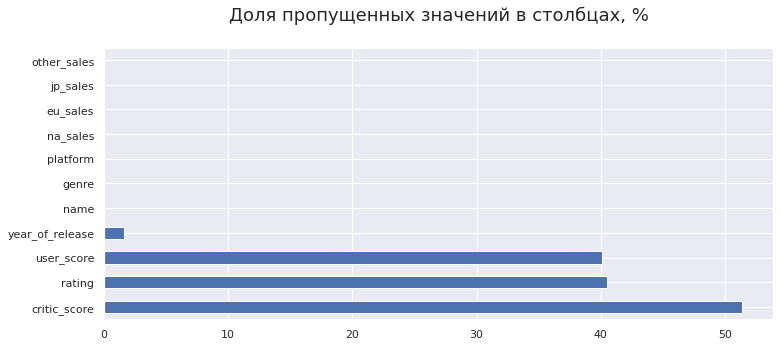

In [104]:
passes = df.isna().mean().sort_values(ascending=False)*100
passes.plot(kind='barh', figsize=(12,5))\
  .set_title('Доля пропущенных значений в столбцах, %'+'\n', fontsize=18);
passes

Очень большой процент пропусков в столбцах critic_score, rating и user_score. С пропусками мы поработаем ниже.

Проверим, есть ли явные дубликаты

In [105]:
df.duplicated().sum()

0

Явных дубликатов нет

## 2. Предобработка данных <a id="data_prep"></a></div>

### 2.1 Название и жанр

Количество уникальных названий

In [106]:
df.name.nunique()

11559

Жанры

In [107]:
df.genre.unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

Пропуски 

In [108]:
df[df.name.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В столбцах name и genre у нас по 1 сотой доли процента пропусков, это две строчки. И в них же не заполнен жанр игры. Эти данные для нас сбсолютно бесполезны, поэтому смело удалим их.

In [109]:
df = df[~df.name.isna()].copy()

### 2.2 Год выпуска

В столбце year_of_release 1.6 процентов пропусков. 

In [110]:
years_of_life = df.pivot_table(index='platform',values='year_of_release',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life

,min,max,years_of_life
platform,,,
2600,1980.0,1989.0,9.0
3DO,1994.0,1995.0,1.0
3DS,2011.0,2016.0,5.0
DC,1998.0,2008.0,10.0
DS,1985.0,2013.0,28.0
GB,1988.0,2001.0,13.0
GBA,2000.0,2007.0,7.0
GC,2001.0,2007.0,6.0
GEN,1990.0,1994.0,4.0


Для Atari 2600 последняя игра получилась выпущена в 2002 году, хотя платформа старая, из 70х годов и ее поддержку отключили аж в 1992м. С Nintendo64 тоже самое - ее перестали поддерживать в 2002.
Выходит, это какая-то ошибка в данных.

In [111]:
df[df.year_of_release.isna()]['platform'].value_counts()

PS2     34
Wii     34
X360    30
DS      30
PS3     25
XB      21
2600    17
PC      17
PSP     16
GC      14
GBA     11
3DS      8
PS       7
N64      3
GB       1
PSV      1
Name: platform, dtype: int64

По новым платформам, которые мы относим к актуальному периоду, не имеют пропусков в столбце год выпуска. По более старым платформам можно их удалить.

In [112]:
df = df.dropna(subset=['year_of_release']).copy()

In [113]:
df['year_of_release'] = df.year_of_release.astype('int')

### 2.3 Оценка пользователей и критиков

В столбцах rating, user_score у нас по 40% пропусков, а в толбце critic_score больше половины. Посмотрим, связанно ли это с годом выпуска игры, предполагая что возможно более старые игры не имеют рейтингов и оценок ввиду отсутствия в 1980е и 1990е года соответствующих интернет сервисов

Количество пропусков в столбце с оценкой пользователей по каждому году:

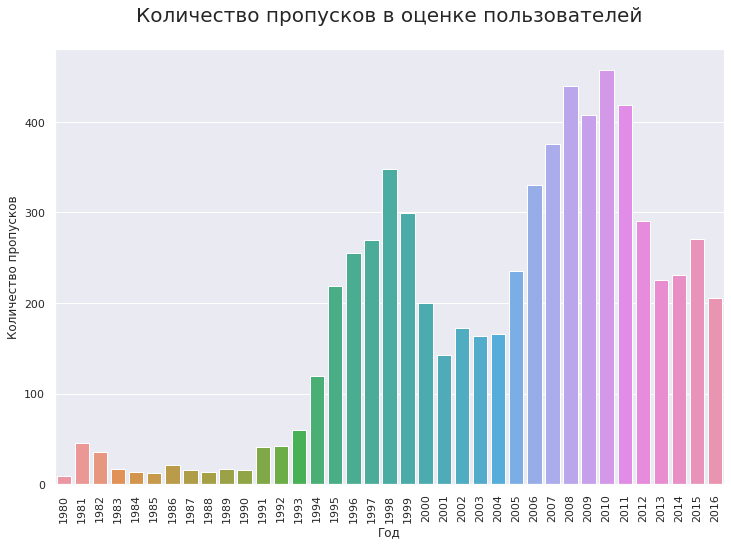

In [114]:
ax = sns.countplot(data=df[df.user_score.isna()], x='year_of_release')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Количество пропусков в оценке пользователей'+'\n', fontsize=20)
plt.xlabel('Год')
plt.ylabel('Количество пропусков');

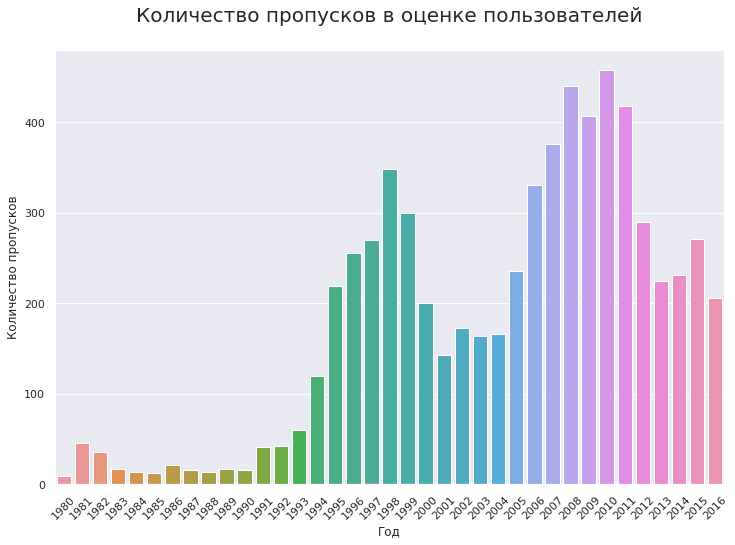

In [115]:
ax = sns.countplot(data=df[df.user_score.isna()], x='year_of_release')
ax.set_title('Количество пропусков в оценке пользователей'+'\n', fontsize=20)
plt.xlabel('Год')
plt.ylabel('Количество пропусков')
plt.xticks(rotation=45);

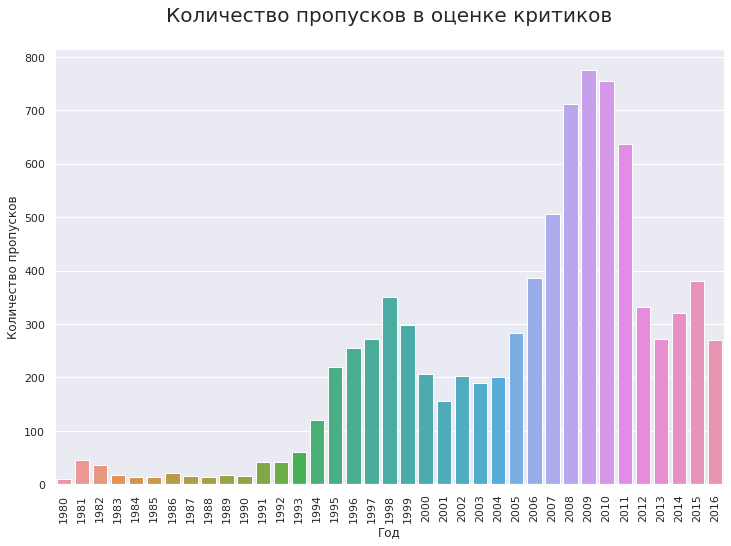

In [116]:
ax = sns.countplot(data=df[df.critic_score.isna()], x='year_of_release')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Количество пропусков в оценке критиков'+'\n', fontsize=20)
plt.xlabel('Год')
plt.ylabel('Количество пропусков');

Наше предположение оказалось неверным, Оценки отсутствуют для игр всех годов выпуска, вплоть до 2016.

Посмотрим пропуски в оценках пользователей в зависимости от платформы:

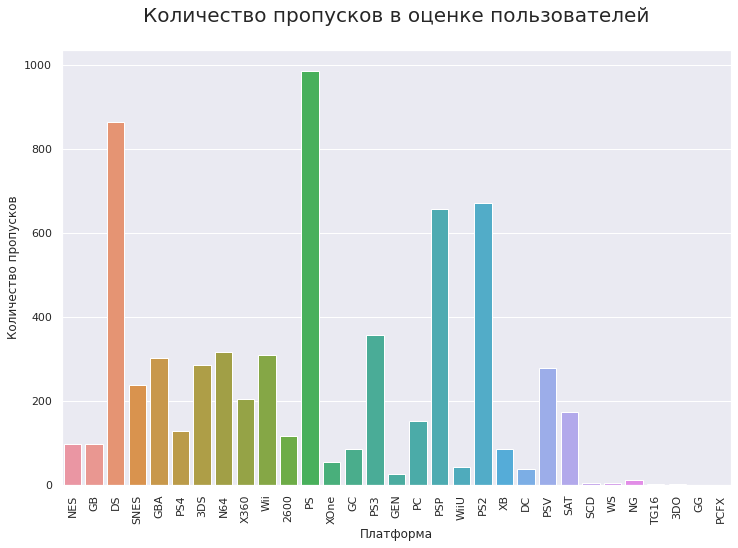

In [117]:
ax = sns.countplot(data=df[df.user_score.isna()], x='platform')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Количество пропусков в оценке пользователей'+'\n', fontsize=20)
plt.xlabel('Платформа')
plt.ylabel('Количество пропусков');

Пропуски в оценке не зависят и от платформы, хотя поплатформе DS их больше всего.

От платформы так же не зависят пропуски в оценках пользователей, они встречаются везде.

Так как оценки пользователей и критиков, а так же рейтинги игр - это уникальные параметры для каждой игры(и скорее всего по разным регионам они тоже разные), то заполнить эти пропуски какими бы то ни было синтетическими данными мы не можем, это приведет к искажению данных. Удалить мы их тоже не можем, слишком большая часть данных будет утеряна.

Отдельно обратим внимание на значение tbd в столбце user_score

In [118]:
df.user_score.unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Таких строк у нас почти 2400

In [119]:
df[df.user_score=='tbd']['user_score'].count()

2376

Значение tbd - to be determined, может означать, что данные об оценках пользователей еще не загружены. Возможно, это игры, выпущенные в 2016 году и оценки пользователей пока в обработке. Посчитаем, сколько таких значений встречается в играх выпущенных в разные годы:

In [120]:
df[df.user_score == 'tbd'].groupby('year_of_release')['year_of_release'].count()

year_of_release
1997      1
1999      8
2000     43
2001     82
2002    192
2003     95
2004    107
2005    121
2006    124
2007    192
2008    326
2009    405
2010    331
2011    217
2012     24
2013     15
2014     21
2015     38
2016     34
Name: year_of_release, dtype: int64

Наше предположение оказалось неверным, это значение часто встречается в играх выпущенных в разные года. Но так как этих данных у нас нет, заменим tbd на пропуски

In [121]:
df['user_score'] = df.user_score.replace({'tbd':np.nan}).astype('float')

И приведем к целочисленному значения в critic_score

In [122]:
df['critic_score'] = df.critic_score.astype('Int64')

In [123]:
df.critic_score.dtype

Int64Dtype()

### 2.4 Рейтинг ESRB

Посмотрим уникальные значения в rating:

In [124]:
df.rating.unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

И посмотрим количество:

Text(0, 0.5, 'Количество игр')

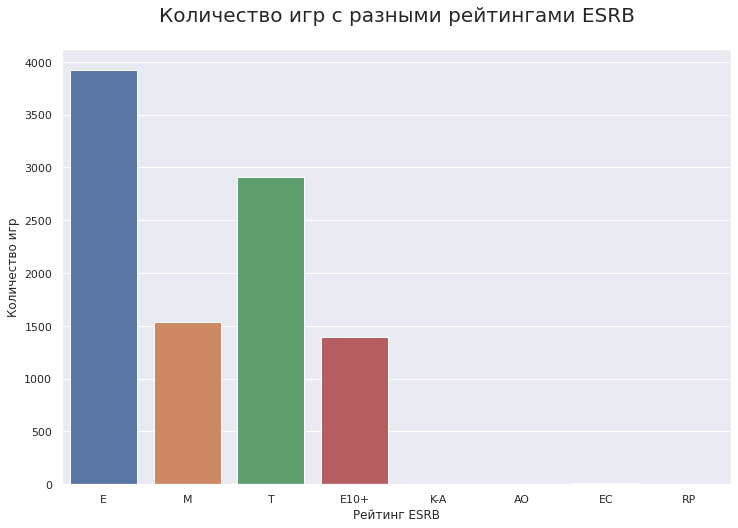

In [125]:
ax = sns.countplot(data=df, x='rating')
ax.set_title('Количество игр с разными рейтингами ESRB'+'\n', fontsize=20)
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Количество игр')
# ax.bar_label(ax.containers[0],fontsize=9);

Видим, что игр с пометками AO, EC, RP прочти нет.

**Вот что значат эти аббревиатуры рейтинга ESRB:**

* `EC` («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. 
* `E` («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первоначально `K-A` ("Kids to Adults").
* `E10+` («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови.
* `T` («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.
* `M` («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.
* `AO` («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. 
* `RP` («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга.

In [126]:
df[df.rating.isna()][['name','platform']].value_counts().head(20)

name                                                           platform
 Beyblade Burst                                                3DS         1
Rampage World Tour                                             N64         1
Resident Evil 2                                                N64         1
Resident Evil - Code: Veronica                                 DC          1
Resident Evil (Remake)                                         GC          1
Resident Evil                                                  SAT         1
                                                               PS3         1
Rescue Heroes: Billy Blazes                                    GBA         1
Rengoku II: The Stairway to H.E.A.V.E.N. (jp sales)            PSP         1
Renegade Racers                                                PS          1
Renai Revenge                                                  PSV         1
Renai Banchou: Inochi Meishi, Koiseyo Otome! Love is Power!!!  PSP         1
Rena

Заполним пропуски в рейтингах заглушкой "unknown"

In [127]:
df['rating'] = df.rating.fillna('unknown')

### 2.5 Продажи

Добавим новый столбец, в котором будет содержаться сумма продаж игр по всем регионам:

In [128]:
df['global_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   Int64  
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  global_sales     16444 non-null  float64
dtypes: Int64(1), float64(6), int64(1), object(4)
memory usage: 2.2+ MB


Посмотрим, как распределены значения о продажах игр

In [130]:
sales = [s for s in df.columns if 'sales' in s]
df[sales].describe()

,na_sales,eu_sales,jp_sales,other_sales,global_sales
count,16444.000000,16444.000000,16444.000000,16444.000000,16444.000000
mean,0.264012,0.145930,0.078487,0.047594,0.536023
std,0.818378,0.506716,0.311100,0.188005,1.558786
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.060000
50%,0.080000,0.020000,0.000000,0.010000,0.170000
75%,0.240000,0.110000,0.040000,0.030000,0.470000
max,41.360000,28.960000,10.220000,10.570000,82.540000


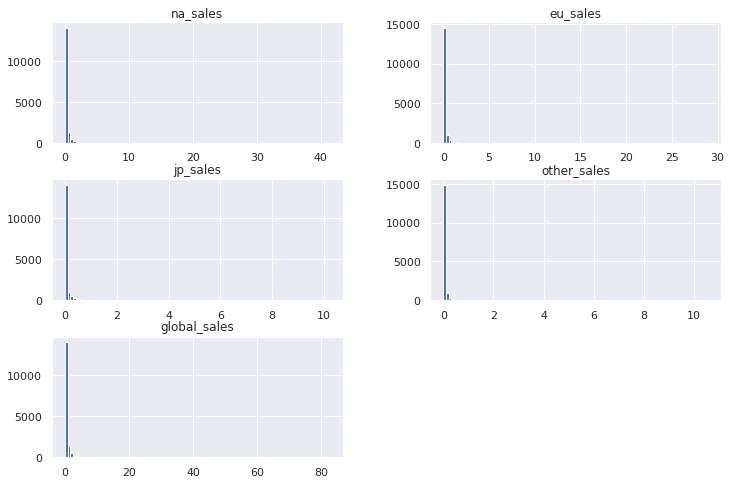

In [131]:
df[sales].hist(bins=100);

Ожидаемо продажи распределены не равномерно, большинство значений ближе к нулю(меньше миллиона проданных копий), но при этом есть очень большие выбросы, то есть бестселлеры, проданные миллионами копий

<font size=5>Промежуточные выводы</font>

После изучения структуры данных и предобработки, можно сказать следующее:


*   Представлены игры с 1980 по 2016 год с параметрами продаж по регионам, жанру, году выпуска, платформе на которой выпускалась игра, возрастной категорией, а так же оценках пользователей и критиков. 
*   Платформа, оценка пользователей, оценка критиков, рейтинг - категориальные признаки. Продажи по разным регионам - непрерывные. 
*   Очень много пропусков параметрах оценки пользователей и критиков, а так же в возрастной категории. 
*   Добавили новый столбец для оценки общих продаж игр по всему миру
*   Продажи разных игр в разных регионах имеют очень большой разброс, при этом много нулевых значений, что конечно аномалия.  



## 3. Исследовательский анализ <a id="eda"></a></div>

### 3.1 Количество игр по годам

Для начала посмотрим, сколько игр выпускалось в разные годы:

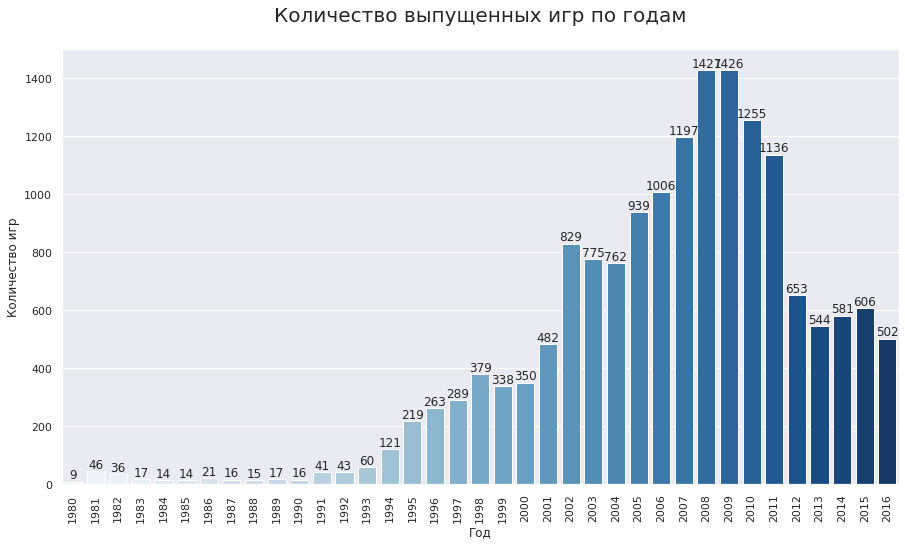

In [132]:
t = df.groupby('year_of_release')['global_sales'].count().reset_index()
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot( x='year_of_release',y='global_sales', data=t, palette='Blues')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Количество выпущенных игр по годам'+'\n', fontsize=20)
plt.xlabel('Год')
plt.ylabel('Количество игр')
# ax.bar_label(ax.containers[0],fontsize=9);
ax.bar_label(ax.containers[0]);


На графике отчетливо видно что до 1998 года игр выпускалось очень мало, потом заметен активный рост с пиком на 2008 и 2009 годах. С 2012 года наблюдаем некоторый спад, хотя, возможно, это стабилизация выпуска игр для представленных платформ. Не будем забывать, что за 2016 год у нас могут быть неполные данные.

Очевидно, что более чем 30-ти летний период развития игровой индустрии имел различные этапы, и для нашего исследования вряд ли нам нужны данные за все годы. 
___

### 3.2 Наиболее популярные платформы

Теперь посмотрим продажи по платформам в разные годы:

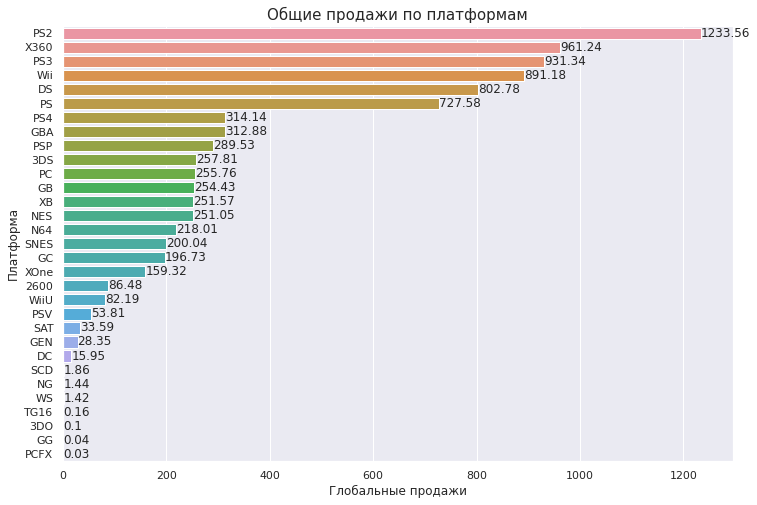

In [133]:
platform_group = df.groupby('platform')['global_sales'].sum()\
                            .reset_index().sort_values(by='global_sales',ascending=False)
ax = sns.barplot(data=platform_group, y='platform', x='global_sales', orient='h')
plt.title('Общие продажи по платформам', fontsize=15)
plt.xlabel('Глобальные продажи')
plt.ylabel('Платформа')
ax.bar_label(ax.containers[0]);

Лидеры по продажам это Play Station 2, Xbox360, Play Station 3, Nintendo Wii, Nintendo DS и Play Station 1.

Возьмем эти 6 платформ:

In [134]:
pop_platforms = platform_group.head(6)['platform'].to_list()
pop_platforms

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

Сгруппируем данные

In [135]:
pop_platforms_df = df[(df.platform.isin(pop_platforms)) & (df.year_of_release > 1992)]\
.pivot_table(index='year_of_release', columns='platform', values='global_sales', aggfunc='sum')


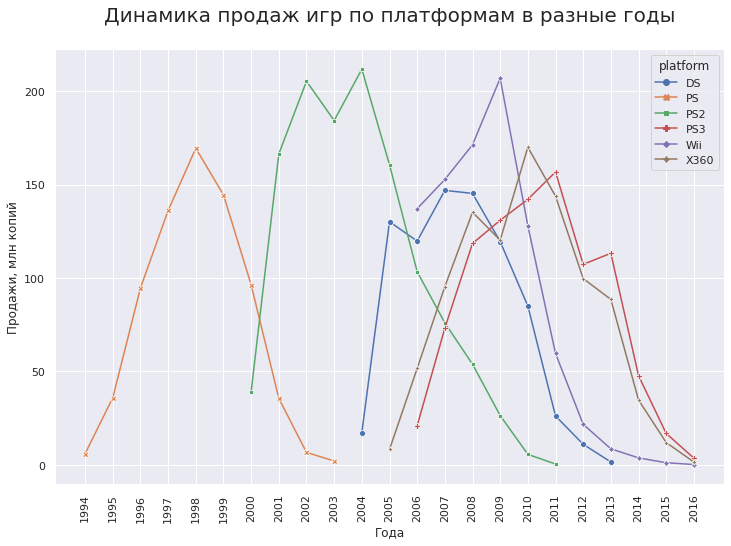

In [136]:
ax = sns.lineplot(data=pop_platforms_df, dashes=False, markers=True)
plt.rcParams["figure.figsize"] = (20,10)
ax.set_title('Динамика продаж игр по платформам в разные годы' + '\n', fontsize=20)
plt.xticks(ticks=range(1994,2017))
ax.tick_params(axis='x', rotation=90)
plt.xlabel('Года')
plt.ylabel('Продажи, млн копий');

На графике мы видим очевидную периодичность жизни различных платформ. То есть наблюдается рост продаж, затем пик или небольшое плато, после чего спад и прекращение продаж. Так же видно, как с уходом платформы предыдущего поколения появляется платформа нового поколения, например PS и PS2 в 2000-2001 годах.
Игры для некоторых платформ(PS3, X360, Wii) продавались и по 2016 год включительно.
Рассчитаем это "время жизни" платформы.


Мы не будем рассматривать платформы, которые были актуальны на 2016 год. Это PS4, XboxOne, 3DC, PC и WiiU

In [137]:
temp = df[~df.platform.isin(['PS4','XOne','3DO','PC','WiiU'])].copy()
max_year = temp.groupby('platform')['year_of_release'].max()
min_year = temp.groupby('platform')['year_of_release'].min()

In [138]:
platform_lifetime = max_year - min_year
platform_lifetime.reset_index()
print('Среднее время жизни:', platform_lifetime.mean())
print('Медианное время жизни:',platform_lifetime.median())

Среднее время жизни: 7.461538461538462
Медианное время жизни: 7.5


Среднее значение времени жизни платформы и медиана практически совпадают. То есть примерно 7 с половиной лет проходит с момента релиза платформы и начала продаж игр для нее до момента когда платформа устаревает и теряет актуальность, на смену ее приходят новые более современные. Этот период мог бы быть полезным для определения актуального периода для нашего исследования, то есть можно было бы взять данные за 2009-2016 года для нашего исследования.

### 3.3 Определение Актуального периода для исследования

Посмотрим как вели себя глобальные продажи и выпуск новых игр в зависимости от года:

In [139]:
years_group = df.groupby('year_of_release')[['global_sales']].sum()\
                        .join(df.groupby('year_of_release')['name'].count())

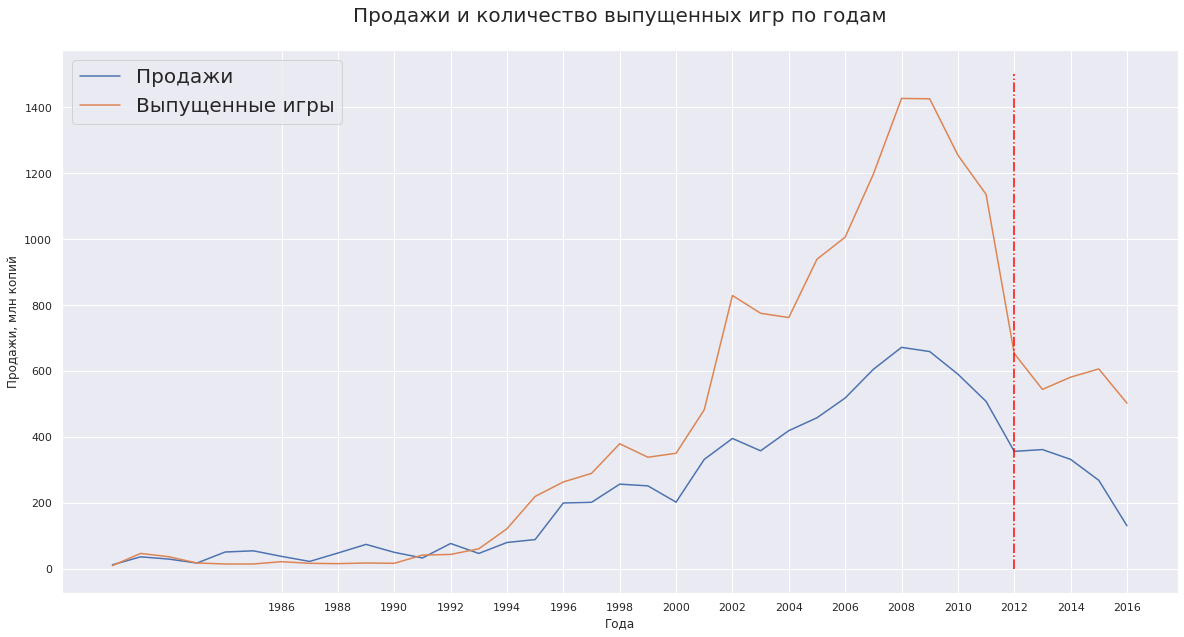

In [140]:
ax = sns.lineplot(data=years_group, dashes=False)
plt.rcParams["figure.figsize"] = (20,10)
ax.set_title('Продажи и количество выпущенных игр по годам' + '\n', fontsize=20)
plt.xticks(range(1986,2017,2))
ax.legend(['Продажи','Выпущенные игры'], loc='upper left', fontsize=20)
ax.vlines(x=2012, linestyle='-.', color='red', ymin=0, ymax=1500)
plt.xlabel('Года')
plt.ylabel('Продажи, млн копий');

Пик приходится на 2008-2009 годы как по продажам, так и по выпуску новых игр. После него оба признака идут на спад и в 2012 году немного стабилизируются. На графике 2012 год обозначен красной пунктирной линией для наглядности отображения трендов. Так что за актуальный период возьмем данные с 2012 по 2016 год.

In [141]:
df[df.year_of_release > 2011].shape

(2886, 12)

In [142]:
df_new = df[df.year_of_release > 2011].copy()

Наша новая выборка содержит 2899 строк. 

In [143]:
len(df[df.year_of_release > 2013])

1689

In [144]:
len(df[df.year_of_release > 2014])

1108

<font size=4>Важное примечание:</font>

*Спад количества продаж и количества выпускаемых игр на представленных платформах связан в первую очередь с ростом доли рынка мобильных игр на платформах iOS и Android. К 2017 году доля этих игр впервые превысила 50%, но в нашем датасете эти платформы не представлены.*

### 3.4 Выявление перспективных платформ

In [145]:
platform_group = df_new.pivot_table(index='year_of_release', values='global_sales', columns='platform', aggfunc='sum')
platform_group

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


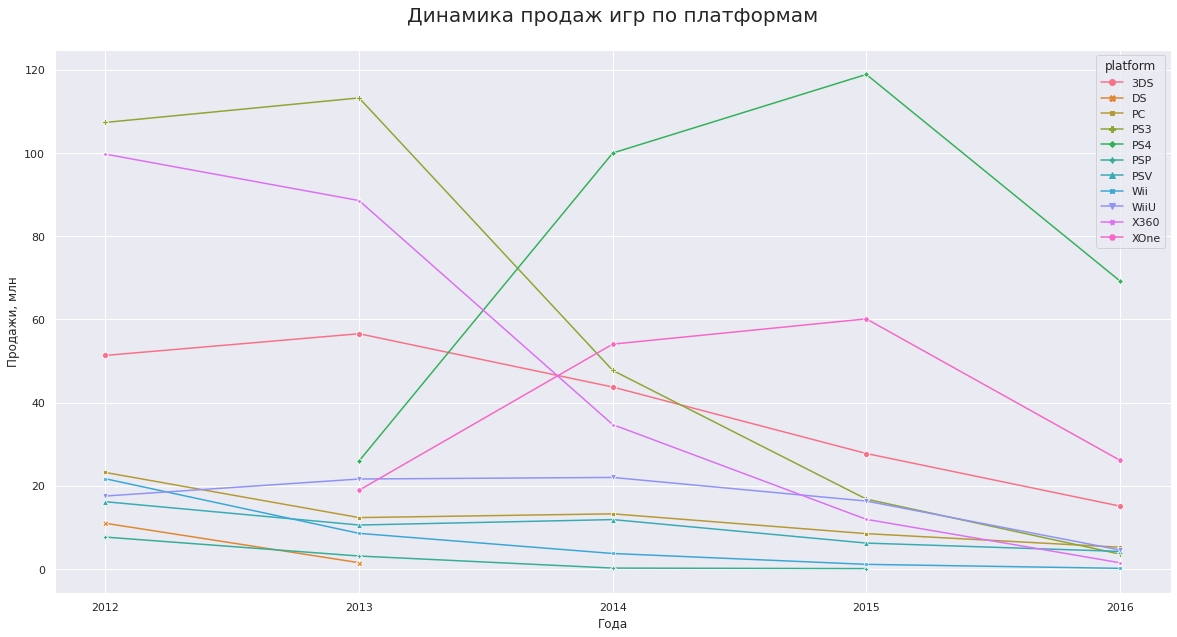

In [146]:
ax = sns.lineplot(data=platform_group, dashes=False, markers=True)
plt.rcParams["figure.figsize"] = (15,10)
ax.set_title('Динамика продаж игр по платформам' + '\n', fontsize=20)
plt.xticks(ticks=range(2012,2017))
plt.xlabel('Года')
plt.ylabel('Продажи, млн');

Мы видим, что по данным на 2016 год в лидерах у нас 4 основные платформы: Nintendo 3DS, Play Station 4, Xbox One и PC. В целом же оглядываясь назад на распределение рынка по всем годам, можно с уверенностью утверждать что лидерами остаются одни и те же производители.

In [147]:
pers_platforms=['3DS','PS4','XOne','PC']

Более наглядное представление продаж по четырем самым популярным платформам. Они же являются наиболее перспективными, несмотря на то что очевиден нисходящий тренд. 

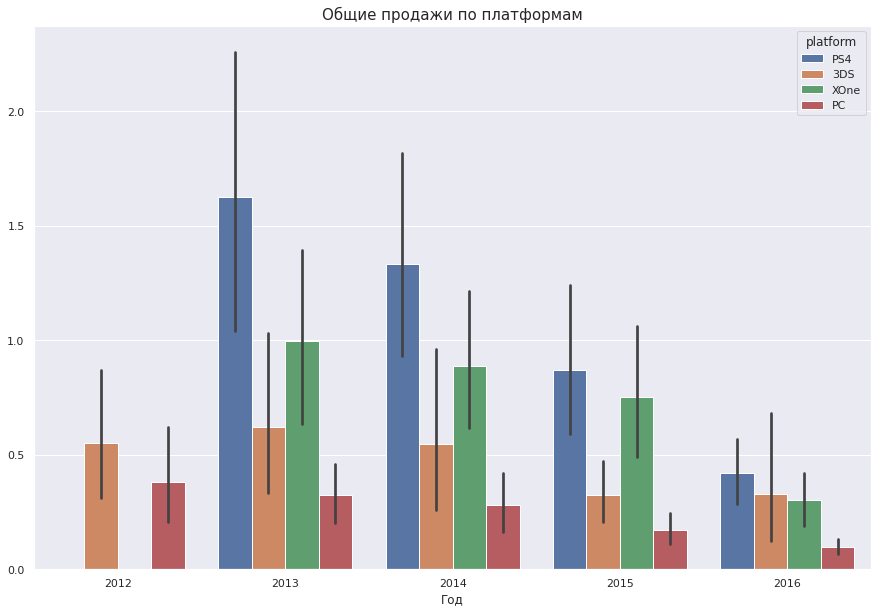

In [148]:
ax = sns.barplot(data=df_new[df_new.platform.isin(pers_platforms)], x='year_of_release', 
                 y='global_sales', hue='platform')
plt.title('Общие продажи по платформам', fontsize=15)
plt.ylabel('')
plt.xlabel('Год');

Ниже представлено статистическое распределение продаж по четырем самым популярным платформам:

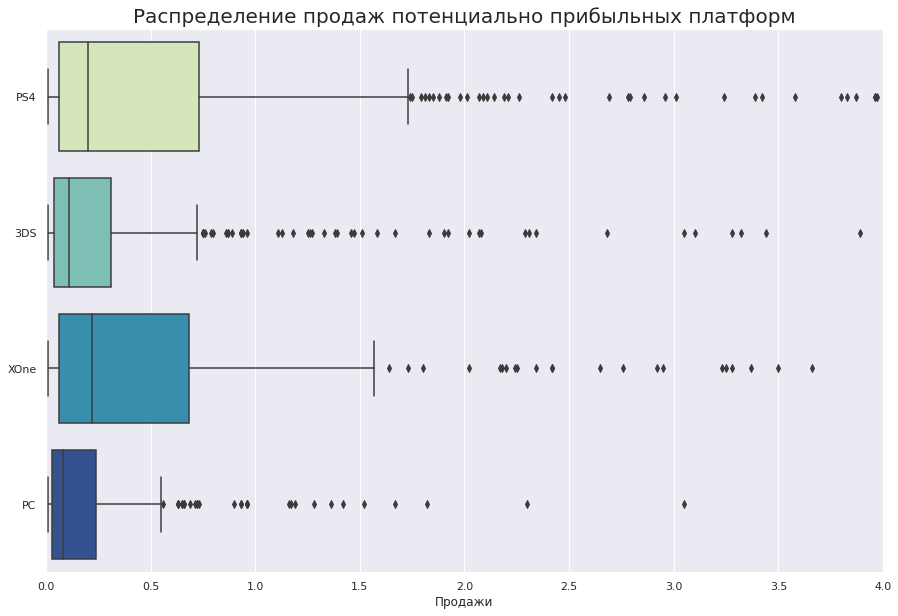

In [149]:
sns.boxplot(y='platform', x='global_sales',
            data = df_new[df_new.platform.isin(pers_platforms)], palette='YlGnBu')
plt.title('Распределение продаж потенциально прибыльных платформ', fontsize=20)
plt.xlim(0,4)
plt.ylabel('')
plt.xlabel('Продажи');


Четко видны два лидера - PS4 и XboxOne, медианные значения у них примерно совпадают равно как и большая часть продаж(это видно на первом и третьем квартилях - начало и конец "коробки"). Самая популярная портативная платформа Nintendo 3DS заметно уступает по количеству продаж, однако мы видим что многие игры держатся на уровне продаж самых популярных стационарных платформ. Игры для персональных компьютеров продаются не в таких объемах как для игровых консолей, хотя держат планку на протяжении десятилетий.

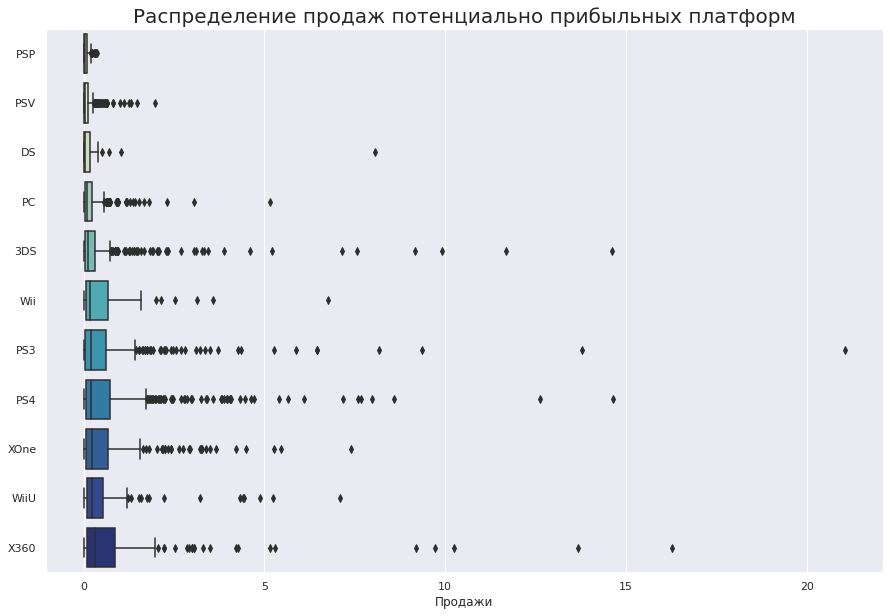

In [150]:
order = df_new.groupby('platform')['global_sales'].median().sort_values(ascending=False).iloc[::-1].index
sns.boxplot(y='platform', x='global_sales',
            data = df_new, palette='YlGnBu', order = order)
plt.title('Распределение продаж потенциально прибыльных платформ', fontsize=20)
plt.rcParams["figure.figsize"] = (25,15)
plt.ylabel('')
plt.xlabel('Продажи');

Здесь видно что помимо платформ, описанных выше, есть Xbox 360, Wii и PS3 с хорошими медианными продажами, но это платформы предыдущего поколения, и у них нисходящий тренд, описанный выше.

### 3.5 Влияние оценки пользователей и критиков

#### 3.5.1 Самая популярная платформа из всех наблюдений

<font size=5>Play Station 2</font>

Возьмем самую популярную платформу за все время наблюдений - Sony Play Station 2

In [151]:
df_ps2 = df[df.platform=='PS2'].copy()

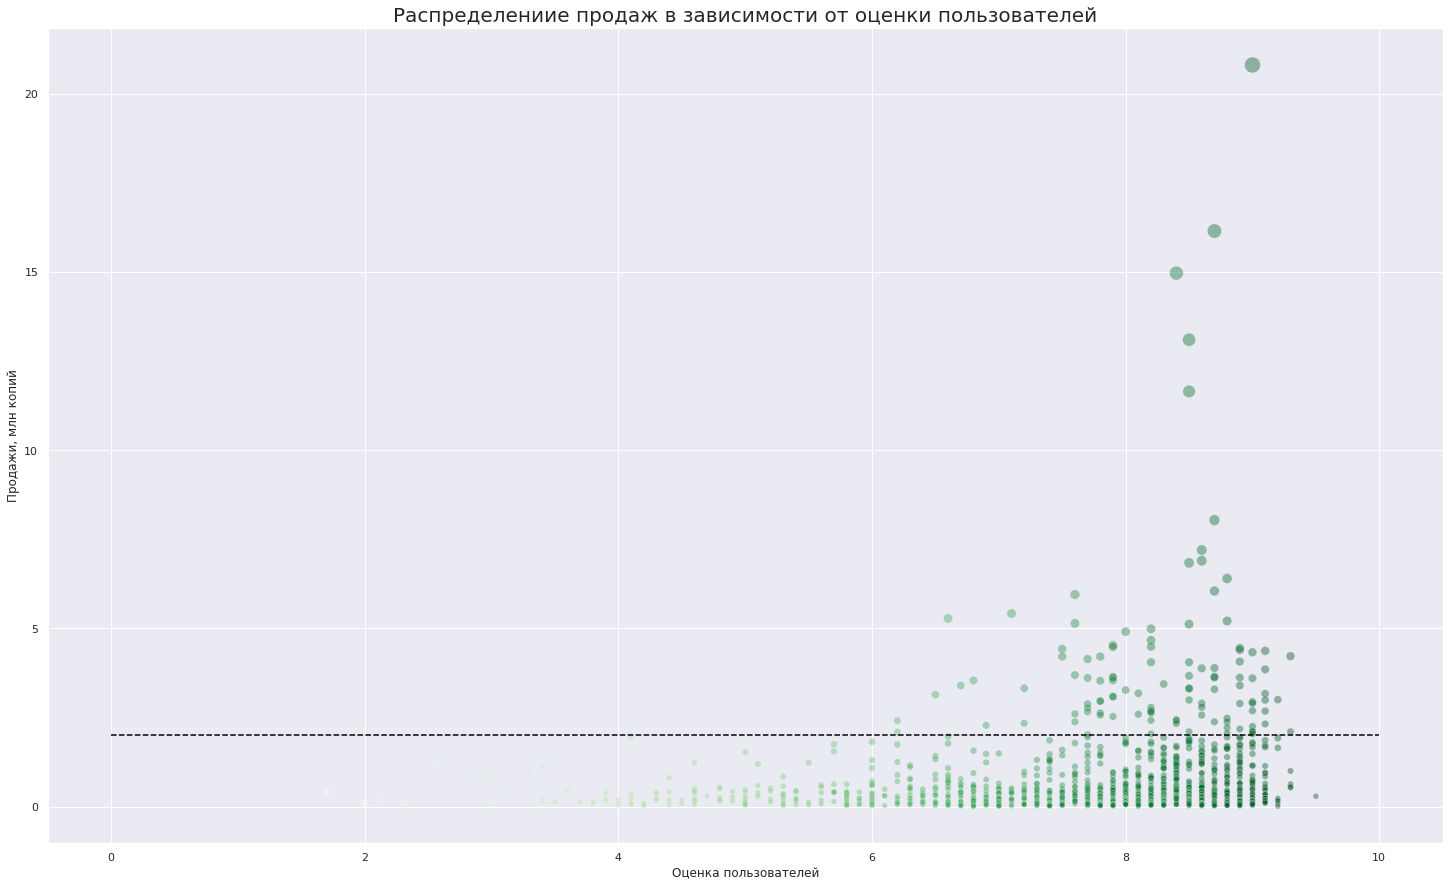

In [152]:
ax = sns.scatterplot(data=df_ps2, x='user_score', y='global_sales', 
                     alpha=0.4, sizes=(30, 250), legend=False, size = 'global_sales', 
                     hue='user_score', palette='Greens')
plt.title('Распределениие продаж в зависимости от оценки пользователей', size=20)
ax.hlines(y=2,linestyle='--',color='black', xmin=0, xmax=10)
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи, млн копий');

Черной пунктирной линией обозначен уровень продаж в 2 миллиона копий. Мы видим, что игр, проданных бОльшим количеством копий с рейтингом пользователей ниже 6 нет, но и в целом игр с рейтингом ниже 6 очень мало. Больше всего игр с рейтингом больше 7. При этом с увеличением оценки пользователей нет заметного роста количества продаж, лиш некоторые отдельные игры продавались в больших количествах. В целом можно сказать, что зависимости продаж от оценок пользователей практически нет. 

Посмотрим коэффициент линейной корреляции. Скорее всего, он будет очень маленьким, иначе бы точки на графике выстроились вдоль воображаемой линии. 

In [153]:
df_ps2['global_sales'].corr(df['user_score'])

0.1750550277038374

Коэффициент Пирсона 0.17 говорит об очень слабой линейной связи между продажами и оценкой пользователей.
____

Теперь посмотрим зависимость продаж от оценок критиков:

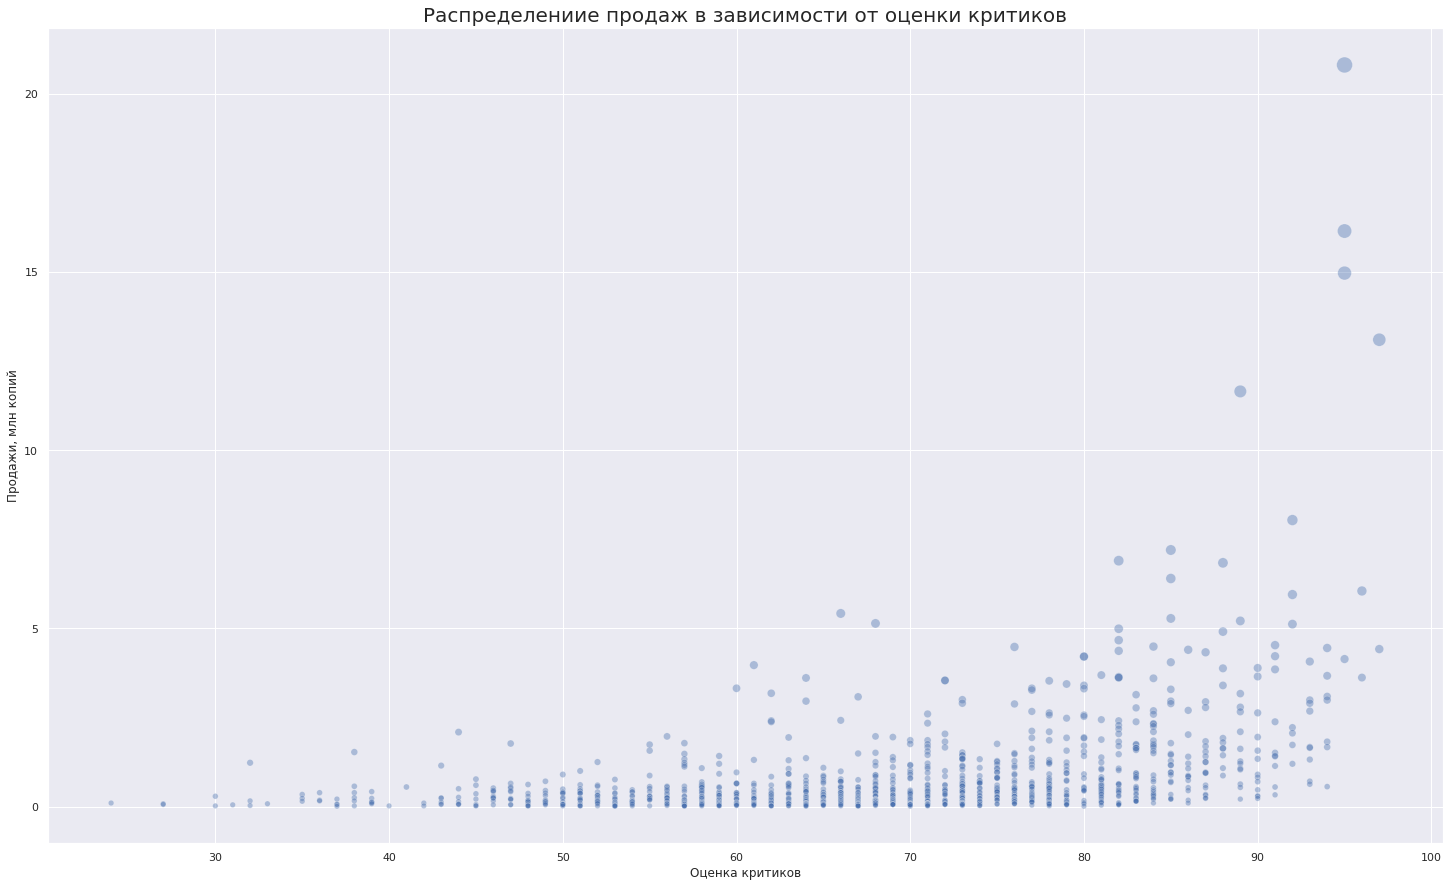

Коэффициент линейной корреляции: 0.39


In [154]:
sns.scatterplot(data=df_ps2, x='critic_score', y='global_sales', 
                alpha=0.4, size = 'global_sales', sizes=(30, 250), legend=False)
plt.title('Распределениие продаж в зависимости от оценки критиков', size=20)
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи, млн копий')
plt.show()
print('Коэффициент линейной корреляции:', round(df_ps2['global_sales'].corr(df_ps2['critic_score'].astype('float64')),2))

Коэффициент Пирсона равен 0.4, что тоже говорит об очень слабой связи, хоть и немного большей, чем в случае с оценками пользователей. После 85 пунктов мы наблюдаем как график "приподнимается", то есть продажи растут, хотя и игр с такими оценками заметно меньше. 

#### 3.5.2 Популярные платформы из актуального периода

Посмотрим на наши 4 самые перспективные платформы:

In [155]:
def scatter_corr(data):
  fig, ax = plt.subplots(1 ,2, figsize=(20,7))
  sns.scatterplot(data=data, x='user_score', y='global_sales', alpha=0.4, sizes=(30, 200),
                  legend=False, size = 'global_sales', hue='user_score', palette='Greens', ax=ax[0])
  sns.scatterplot(data=data, x='critic_score', y='global_sales', alpha=0.4, 
                  sizes=(30, 200), legend=False, size = 'global_sales',ax=ax[1])
  fig.suptitle(data.platform.values[0], fontsize=20)
  ax[0].set(xlabel='Оценка пользователей')
  ax[1].set(xlabel='Оценка критиков')
  ax[0].set(ylabel='Количество продаж')
  ax[1].set(ylabel='Количество продаж')
  plt.show()
  print('Коэффициент линейной корреляции оценки критиков:', round(data['global_sales'].corr(data['critic_score']\
                                                                                            .astype('float64')),2))
  print('Коэффициент линейной корреляции оценки пользователей:', round(data['global_sales'].corr(data['user_score']),2))

In [156]:
pers_platforms

['3DS', 'PS4', 'XOne', 'PC']

<font size=5>Play Station 4</font>

In [157]:
df_PS4 = df_new[df_new.platform == 'PS4'].copy()

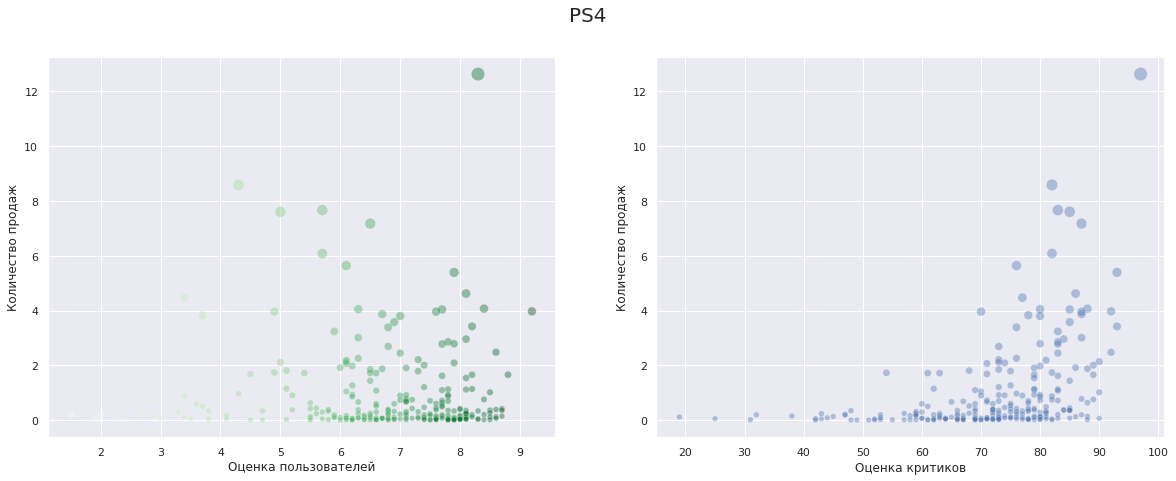

Коэффициент линейной корреляции оценки критиков: 0.41
Коэффициент линейной корреляции оценки пользователей: -0.03


In [158]:
scatter_corr(df_PS4)

Коэффициент корреляции Пирсона в случае с оценками пользователей равен 0, и на графике мы видим как "разбросаны" игры. Есть в том числе игры с оценкой ниже 6, но с продажами в несколько миллионов копий. Оценки пользователей никак не влияют на продажи. На графике оценок критиков мы видим небольшой подъем ближе к оценке в 90 пунктов. 

<font size=5>Xbox One</font>

In [159]:
df_XOne = df_new[df_new.platform == 'XOne'].copy()

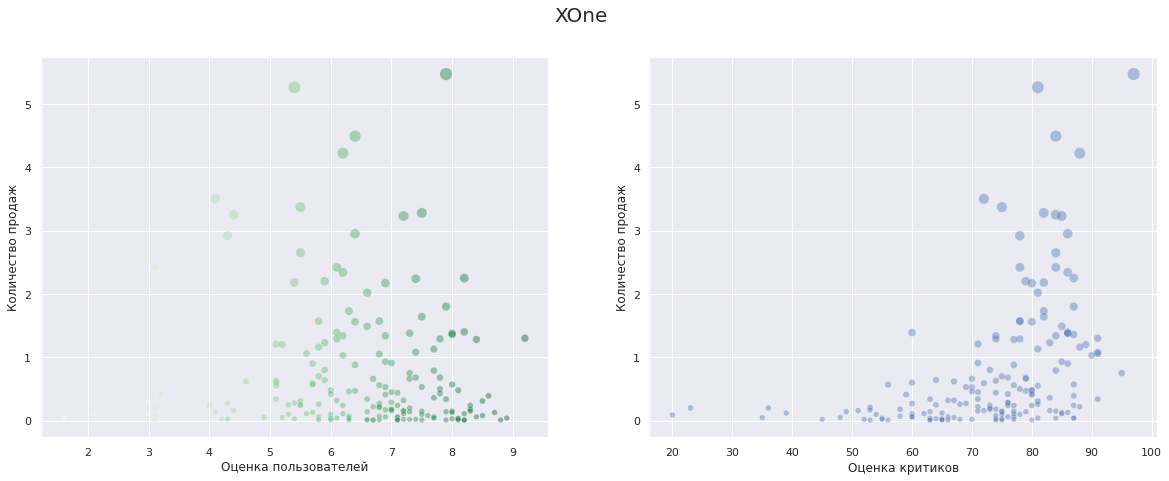

Коэффициент линейной корреляции оценки критиков: 0.42
Коэффициент линейной корреляции оценки пользователей: -0.07


In [160]:
scatter_corr(df_XOne)

Картина идентичная PS4.

<font size=5>Nintendo 3DS</font>

In [161]:
df_3DS = df_new[df_new.platform == '3DS'].copy()

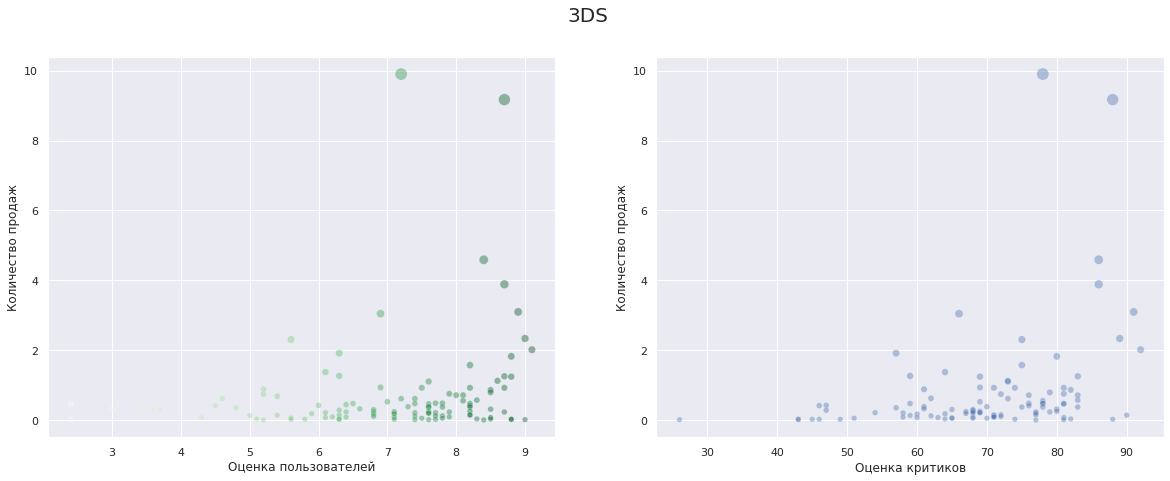

Коэффициент линейной корреляции оценки критиков: 0.32
Коэффициент линейной корреляции оценки пользователей: 0.2


In [162]:
scatter_corr(df_3DS)

Опять же видим такую же картину

<font size=5>PC</font>

In [163]:
df_PC = df_new[df_new.platform == 'PC'].copy()

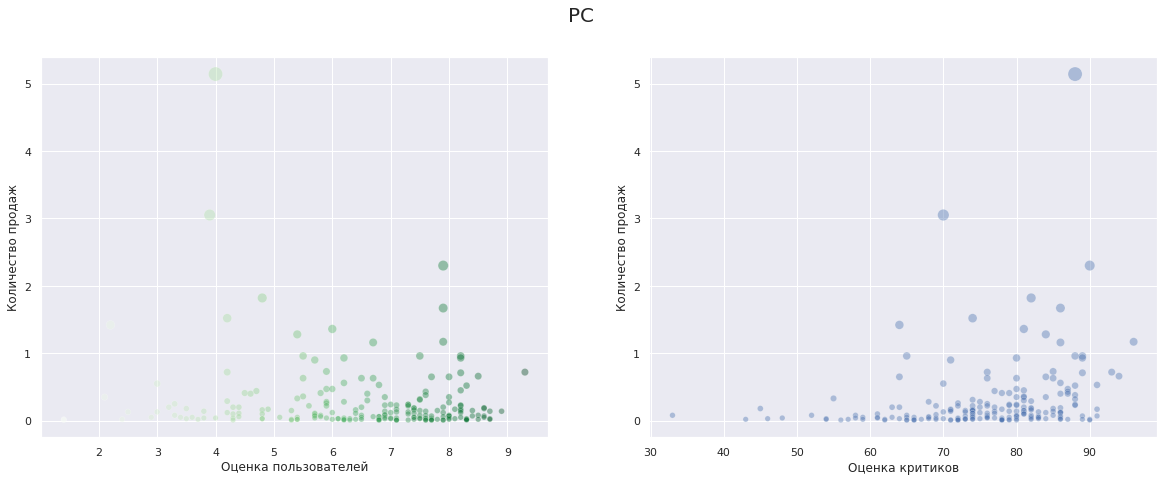

Коэффициент линейной корреляции оценки критиков: 0.24
Коэффициент линейной корреляции оценки пользователей: -0.12


In [164]:
scatter_corr(df_PC)

<font size=5>Вывод:</font>

Оценки пользователей и оценки критиков никак не влияют на количество проданных копий игр. Мы наблюдаем одинаковую картину по всем актуальным платформам. Есть игры с хорошими оценками, но их продажи крайне невелики. Одновременно есть игры с довольно низким рейтингом, которые продавались миллионами копий. Единственное, что можно сказать - при оценке критиков выше 85 пунктов игры в среднем продаются чуть лучше, чем остальные. Но говорить о какой-либо зависимости или сильной связи не приходится.

### 3.6 Распределение игр по жанрам

Посмотрим, сколько игр каждого жанра выпускалось в актуальный период:

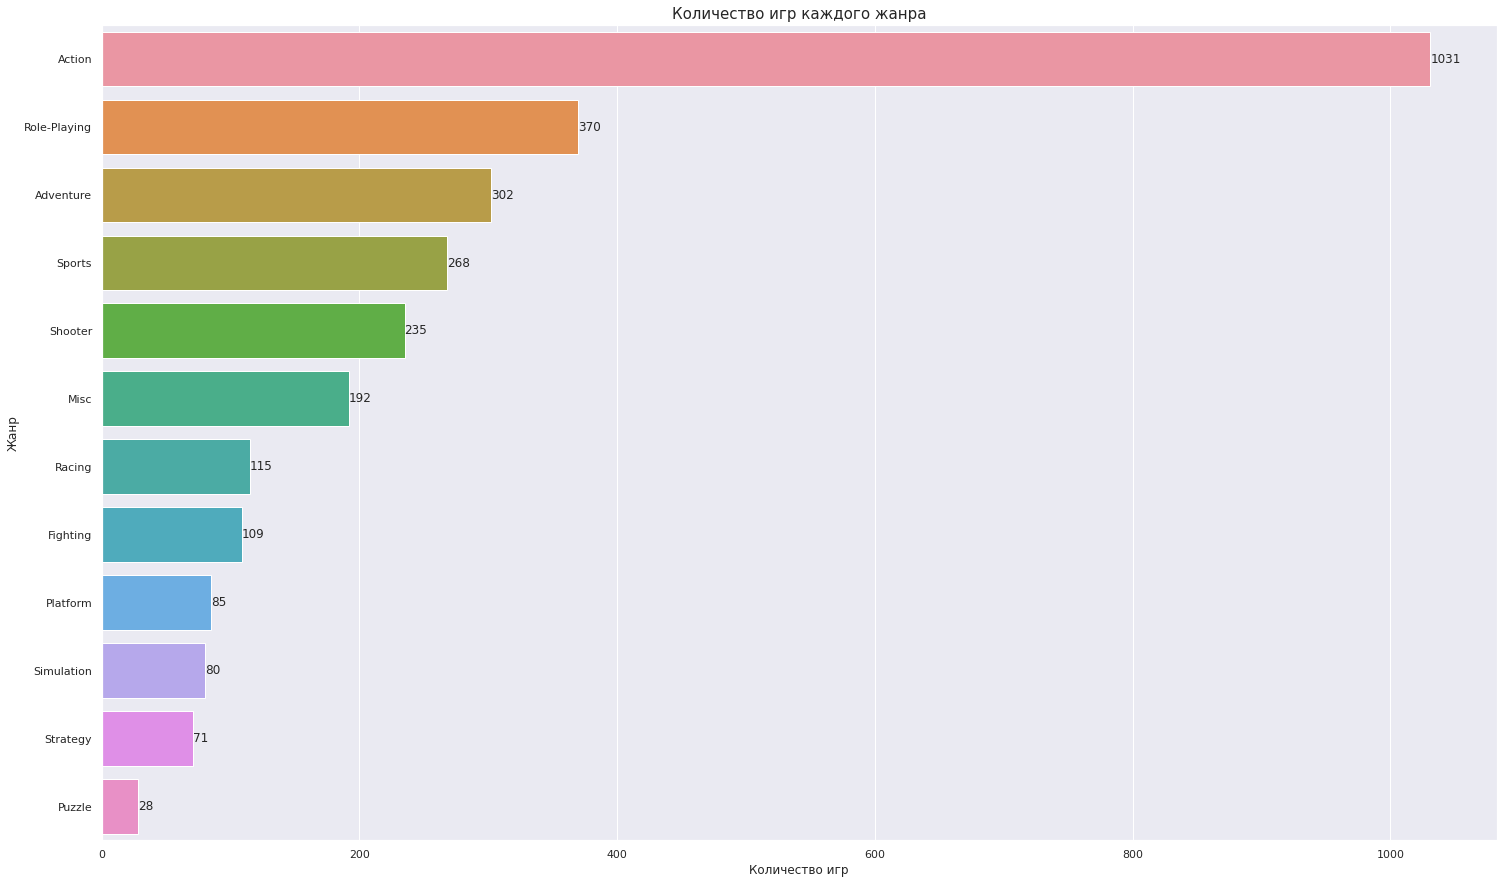

In [165]:
ax = sns.countplot(data=df_new, y='genre', orient='h',order = df_new.genre.value_counts().index)
plt.title('Количество игр каждого жанра', fontsize=15)
plt.xlabel('Количество игр')
plt.ylabel('Жанр')
ax.bar_label(ax.containers[0]);

С большим отрывом лидируют игры в жанре "Action", далее "Role-playing", "Adventure", "Sports", "Shooter", "Misc" и другие. 

Посмотрим, продавались ли игры разных жанров в такой же последовательности, или количество выпущенных игр не означает, что продажи так же распределены?

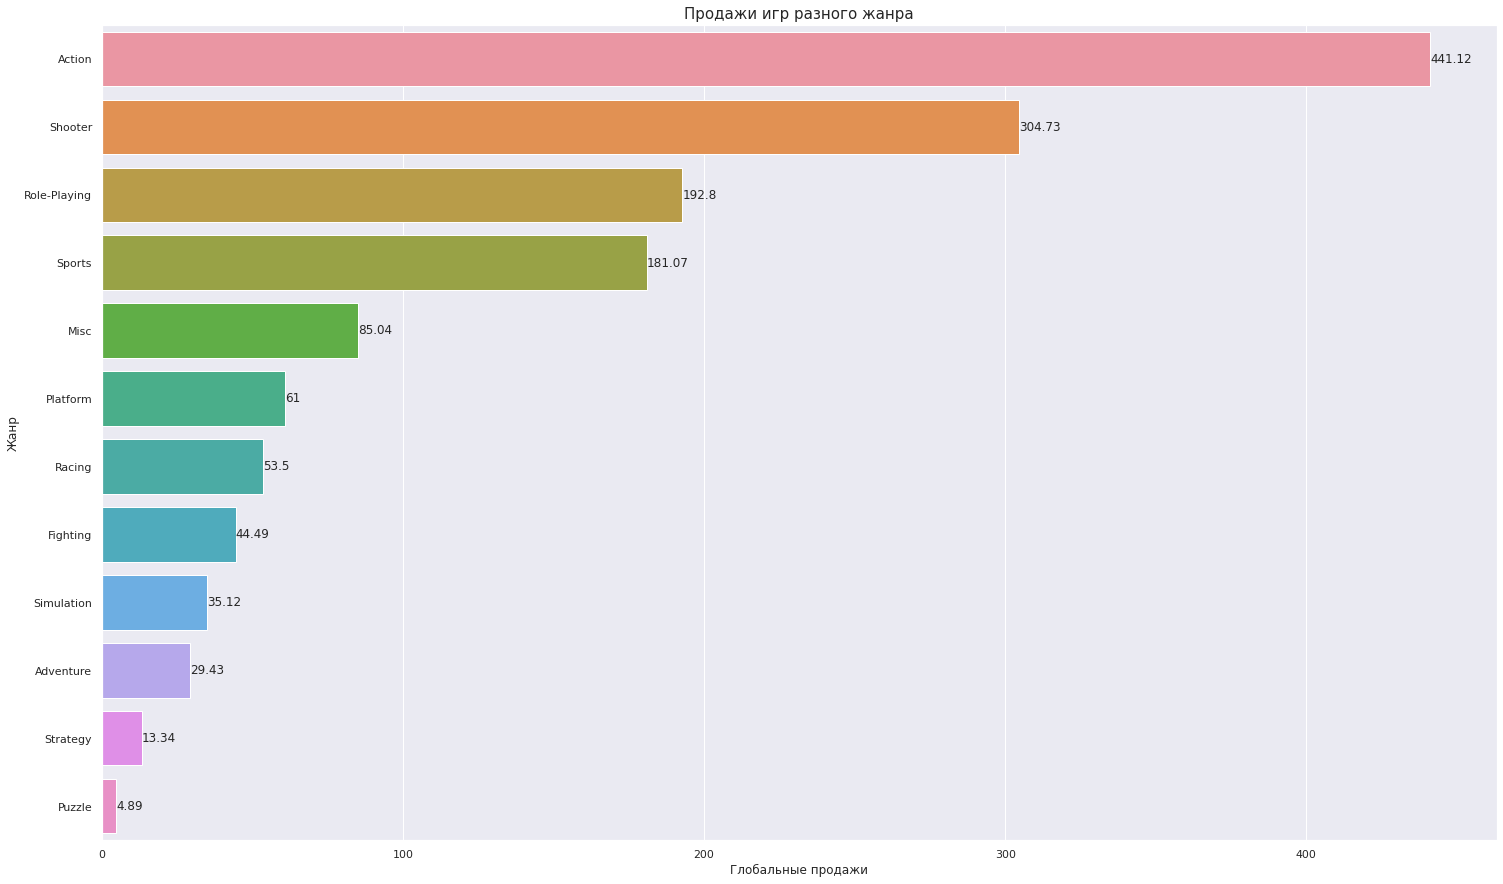

In [166]:
genre_group_sales = df_new.groupby('genre')['global_sales'].sum().reset_index()\
                                            .sort_values(ascending=False,by='global_sales')
ax = sns.barplot(data=genre_group_sales, y='genre', x='global_sales', orient='h')
plt.title('Продажи игр разного жанра', fontsize=15)
plt.xlabel('Глобальные продажи')
plt.ylabel('Жанр')
ax.bar_label(ax.containers[0]);

В лидерах так же игры жанра "Action", а вот на втором месте и с не очень большим отрывом игры "Shooter". То есть несмотря на то что их выпустили почти в 5 раз меньше чем "Action", продавлись они очень активно. На третьем месте игры жанра "Role-playing". Что так же интересно - игры жанра "Adventures" на третьем месте по количеству, а вот по продажам они на третьем месте с конца и имеют незначительную долю в общем объеме продаж. Так же видим что стратегии и головоломки в аутсайдерах.

Интересный факт: игры в жанре "Puzzle" по итогам 2021 года заняли первое место по объему выручки и второе место по количеству скачиваний в США. То есть мы можем наблюдать переход некоторых жанров полностью на мобильные платформы. Стремитеьлный рост мобильных игр кардинально меняло игровую индустрию в 2010х годах. 

Посмотрим топ-4 самых популярных жанра и продажи по годам:

In [167]:
genres = ['Action','Shooter','Role-Playing','Sports']

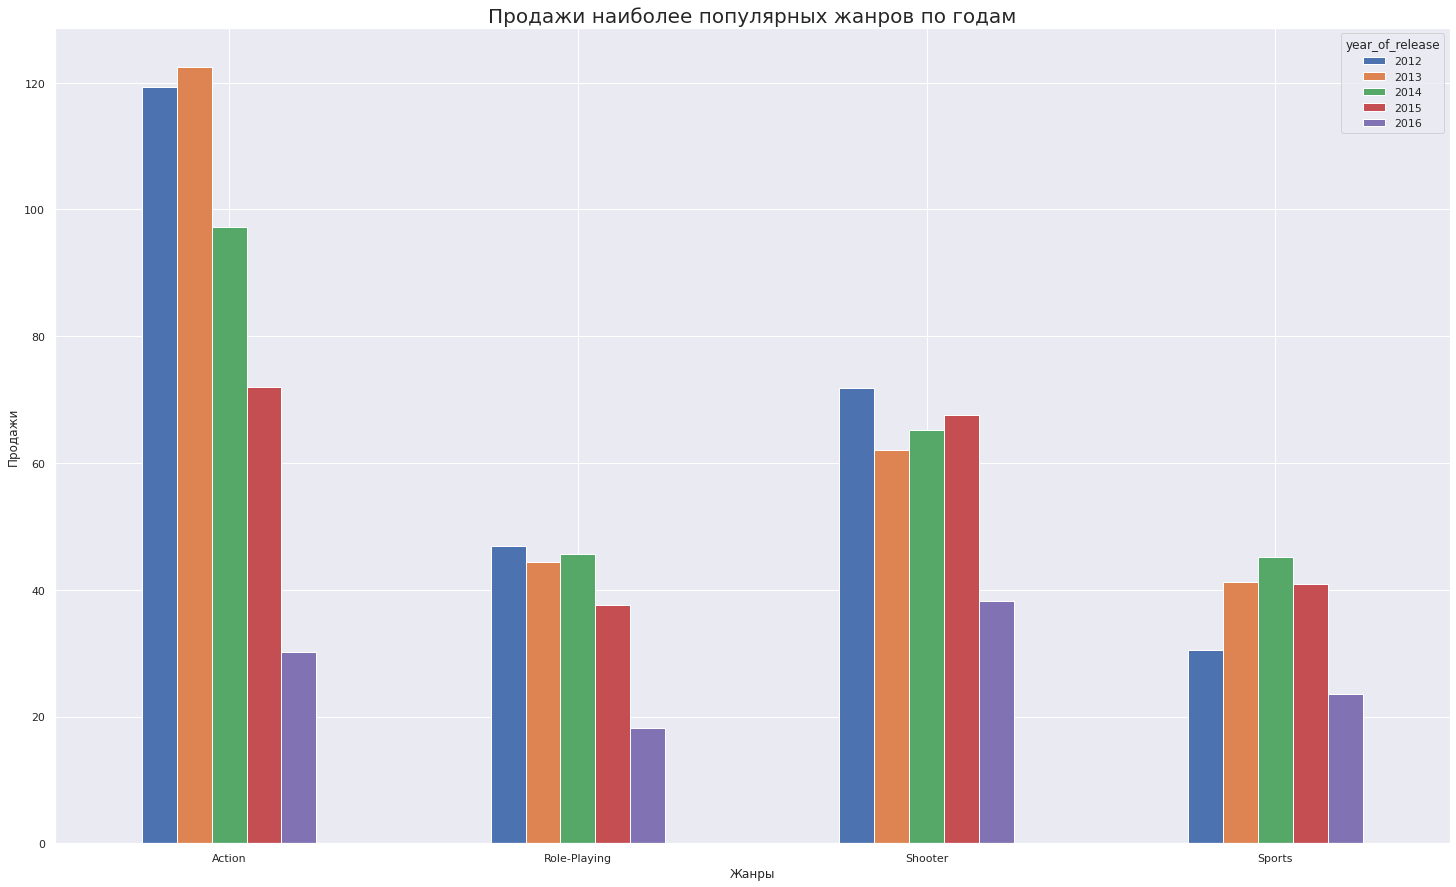

In [168]:
genre_by_year = df_new.pivot_table(index='genre', columns='year_of_release', values='global_sales', aggfunc='sum')\
                                                .reset_index()
genre_by_year[genre_by_year['genre'].isin(genres)].plot(kind='bar', x='genre');
plt.tick_params(axis='x', rotation=0)
plt.title('Продажи наиболее популярных жанров по годам', size=20)
plt.xlabel('Жанры')
plt.ylabel('Продажи');


В целом мы видим ниспадающий тренд по всем четырем жанрам(помним о том, что за 2016 год данные могут быть не полными). Тем не менее, игры в жанре "Shooter" почти не теряют уровня продаж, и в 2016 году превысили самый популярный жанр "Action". Так же в 2016 году больше продавалось игр в жанре "Sport" чем третий по популярности "Role-Playing".

Из-за роста продаж игр на мобильных платформах некоторые жанры постепенно перемещаются в этот сегмент. Но из-за специфики игрового процесса и развития графических технологий можно предположить, что игры в жанре "Shooter" и "Sports" будут иметь высокие продажи на основных популярных платформах.

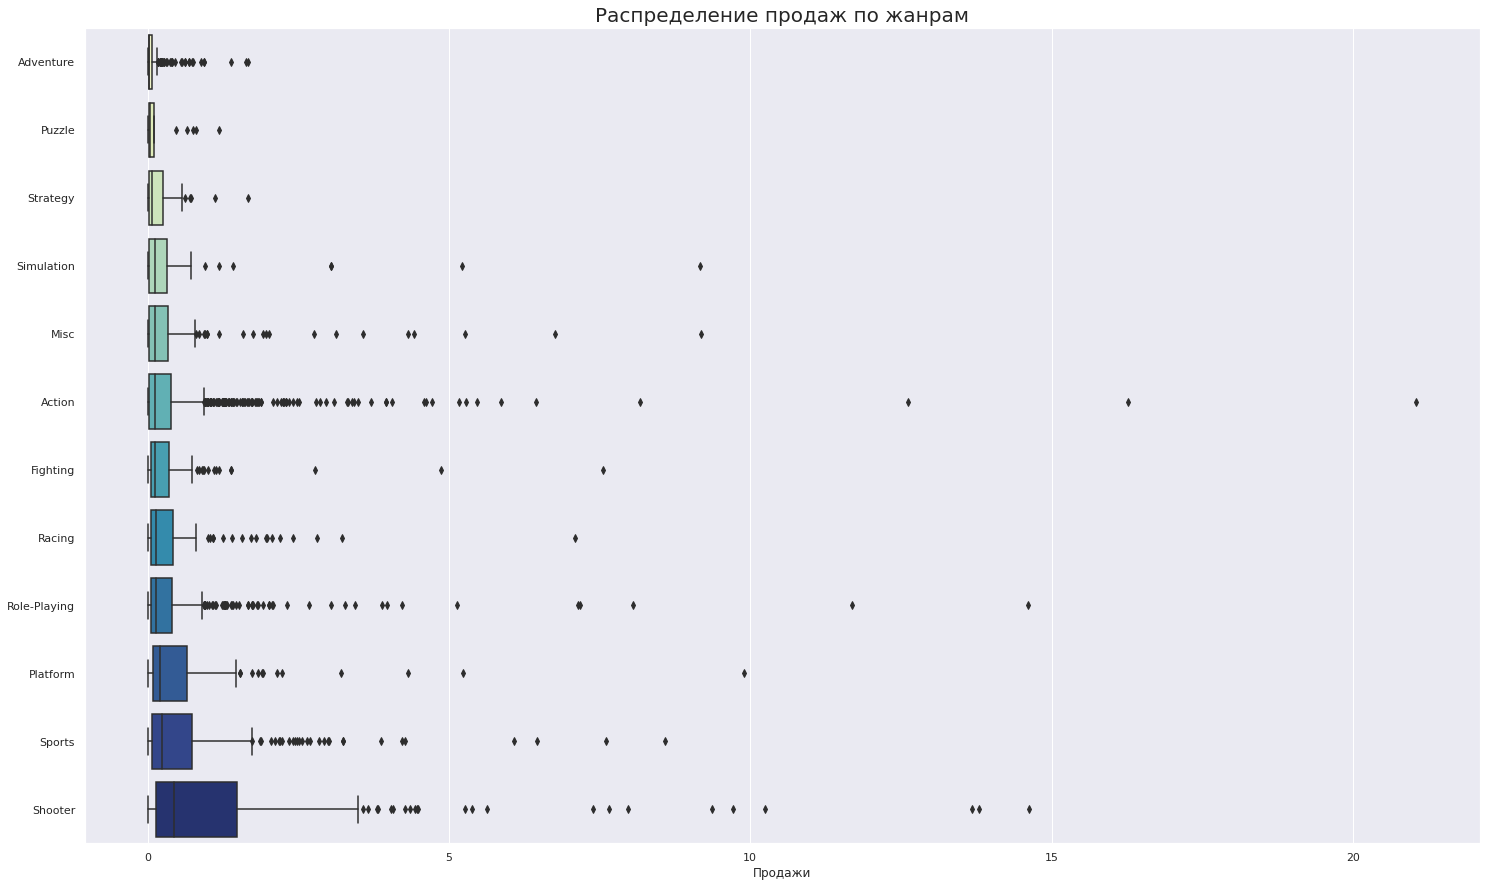

In [169]:
list = df_new.groupby('genre')['global_sales'].median().sort_values(ascending=False).iloc[::-1].index
sns.boxplot(y='genre', x='global_sales',
            data = df_new, palette='YlGnBu', order = list)
plt.title('Распределение продаж по жанрам', fontsize=20)
plt.rcParams["figure.figsize"] = (25,15)
plt.ylabel('')
plt.xlabel('Продажи');

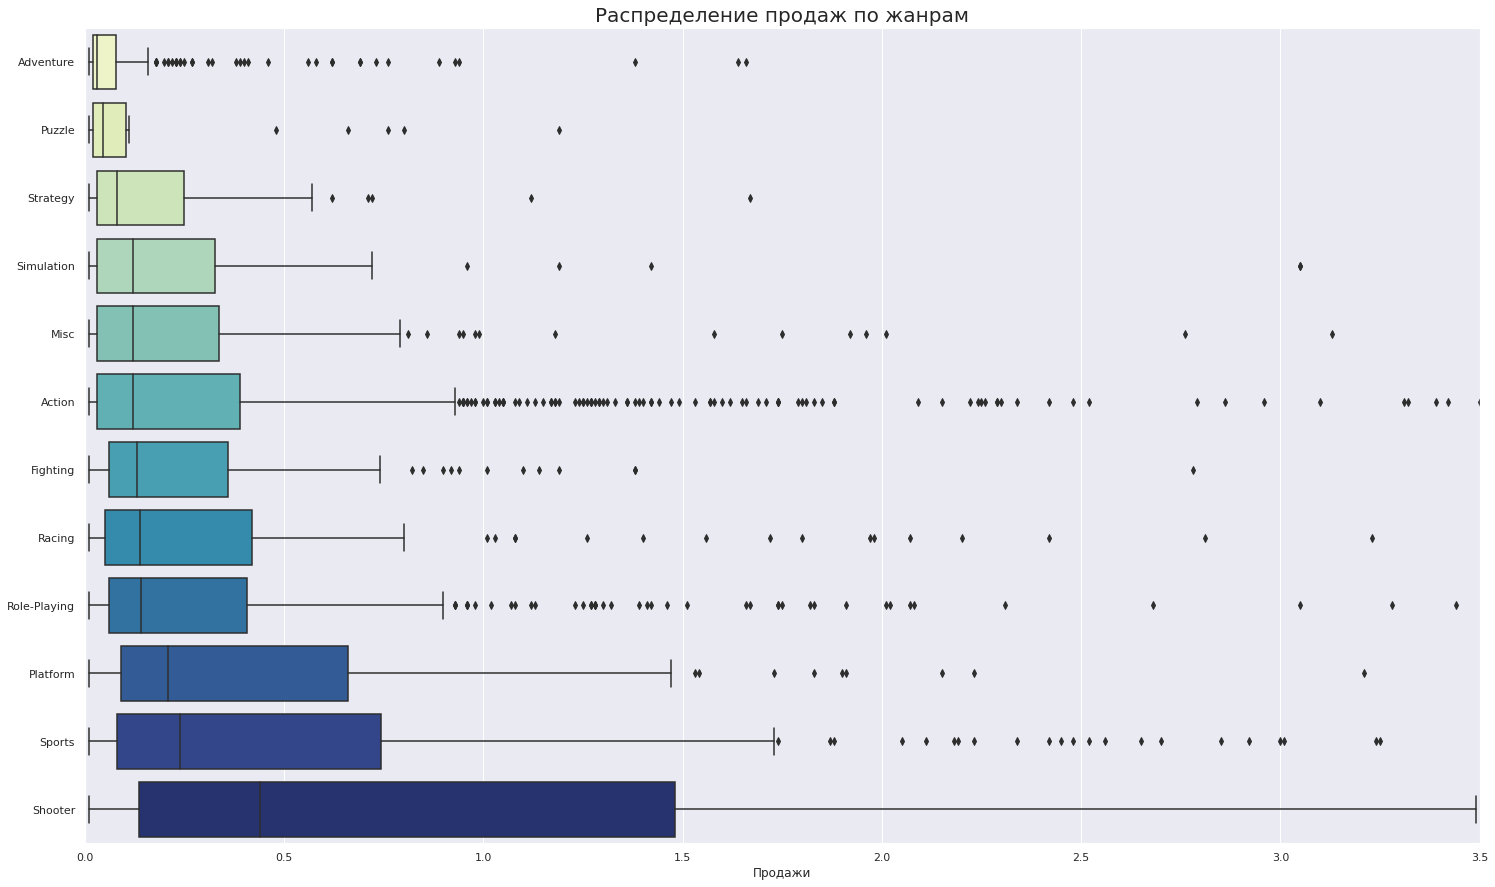

In [170]:
order = df_new.groupby('genre')['global_sales'].median().sort_values(ascending=False).iloc[::-1].index
sns.boxplot(y='genre', x='global_sales',
            data = df_new, palette='YlGnBu', order = order)
plt.title('Распределение продаж по жанрам', fontsize=20)
plt.rcParams["figure.figsize"] = (25,15)
plt.ylabel('')
plt.xlim(0,3.5)
plt.xlabel('Продажи');

Выходит, выбросы выводили жанр Экшн вперед, но вот наиболее стабильны и имеют больше всего успешпо родающихся игр жанры: Shooter, Sports, Platform. Третий квартиль жанра Shooter вообще больше чем многие распределения других жанров.
    
Очень интересное наблюдение!



## 4. Портрет пользователя каждого региона

### 4.1 Самые популярные платформы

Сравним пять самых популярных платформ по продажам в каждом регионе.

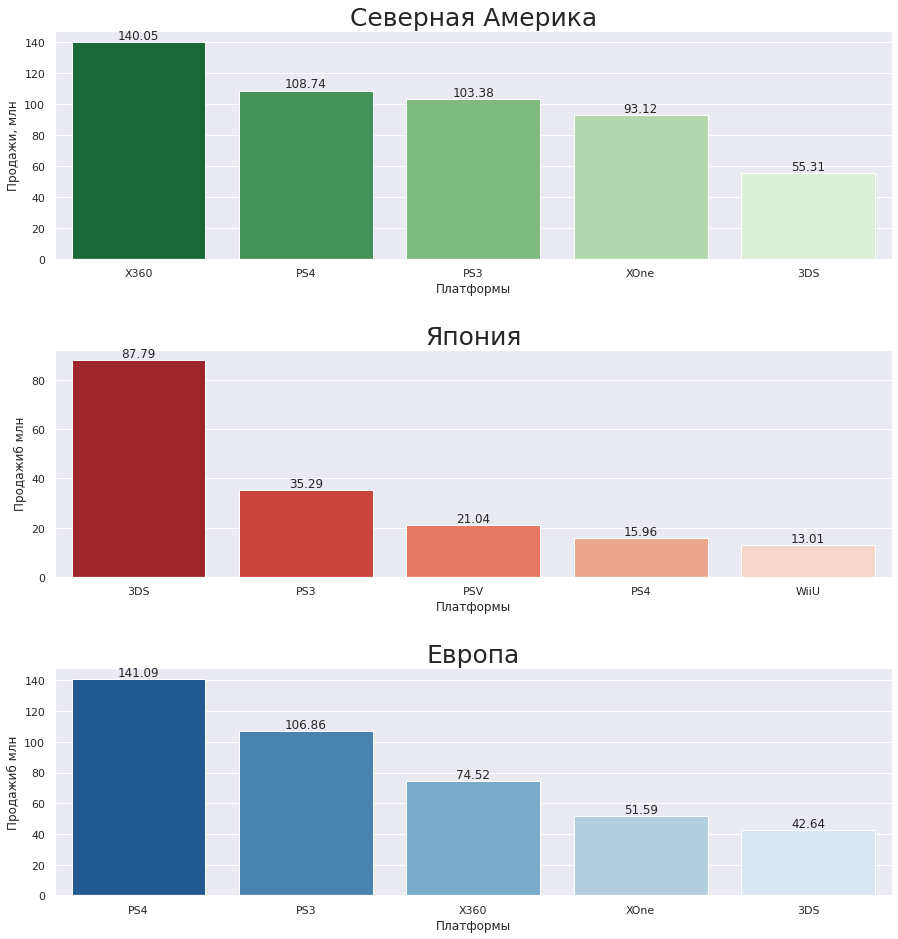

In [171]:
na_platform_group = df_new.groupby('platform')['na_sales'].sum().reset_index()\
                .sort_values(by='na_sales',ascending=False).head()
jp_platform_group = df_new.groupby('platform')['jp_sales'].sum().reset_index()\
                .sort_values(by='jp_sales',ascending=False).head()
eu_platform_group = df_new.groupby('platform')['eu_sales'].sum().reset_index()\
                .sort_values(by='eu_sales',ascending=False).head()

fig, ax = plt.subplots(3, figsize=(15,15))
sns.barplot(data=na_platform_group, x='platform', y='na_sales',ax=ax[0], palette='Greens_r')
sns.barplot(data=jp_platform_group, x='platform', y='jp_sales',ax=ax[1], palette='Reds_r')
sns.barplot(data=eu_platform_group, x='platform', y='eu_sales',ax=ax[2], palette='Blues_r')
ax[0].set_title('Северная Америка', size=25)
ax[1].set_title('Япония', size=25)
ax[2].set_title('Европа', size=25)
ax[0].set(ylabel='Продажи, млн')
ax[1].set(ylabel='Продажиб млн')
ax[2].set(ylabel='Продажиб млн')
ax[0].set(xlabel='Платформы')
ax[1].set(xlabel='Платформы')
ax[2].set(xlabel='Платформы')
ax[0].bar_label(ax[0].containers[0])
ax[1].bar_label(ax[1].containers[0])
ax[2].bar_label(ax[2].containers[0])
plt.subplots_adjust(bottom=0.1,top=0.9,wspace=0.4, hspace=0.4)
  
plt.show()

**Северная Америка.** 

Самая популятная платформа - Xbox 360 от американской компании Microsoft. Далее по популярности Play Station 4 и 3, а на пятом месте портативная платформа 3DS. 

**Япония**

В Японии с большим отрывом лидирует портативная платформа Nintendo 3DS, на третьем месте так же портативная платформа Play Station Vita. Платформ Xbox вообще нет в первой пятерке. То есть в Японии отдают предпочтение портативным консолям, и очень мало играют на Xbox.

**Европа**

В Европе лидеры у нас Play Station 4 и за ней Play Station 3, далее Xbox, а портативная 3DS лишь на пятом месте, так же как и в Северной Америке. 
____


In [172]:
na_platform_group = df_new.groupby('platform')['na_sales'].sum().reset_index()\
                .sort_values(by='na_sales',ascending=False)

na_platform_others = pd.DataFrame([['Others', na_platform_group.tail(len(na_platform_group)-5)\
                                    ['na_sales'].sum()]], columns=['platform','na_sales'], index=[100])
na_platform_group = na_platform_group.head()
na_platform_group = na_platform_group.append(na_platform_others)

In [173]:
jp_platform_group = df_new.groupby('platform')['jp_sales'].sum().reset_index()\
                .sort_values(by='jp_sales',ascending=False)

jp_platform_others = pd.DataFrame([['Others', jp_platform_group.tail(len(jp_platform_group)-5)\
                                    ['jp_sales'].sum()]], columns=['platform','jp_sales'], index=[100])
jp_platform_group = jp_platform_group.head()
jp_platform_group = jp_platform_group.append(jp_platform_others)

In [174]:
eu_platform_group = df_new.groupby('platform')['eu_sales'].sum().reset_index()\
                .sort_values(by='eu_sales',ascending=False)

eu_platform_others = pd.DataFrame([['Others', eu_platform_group.tail(len(eu_platform_group)-5)\
                                    ['eu_sales'].sum()]], columns=['platform','eu_sales'], index=[100])
eu_platform_group = eu_platform_group.head()
eu_platform_group = eu_platform_group.append(eu_platform_others)

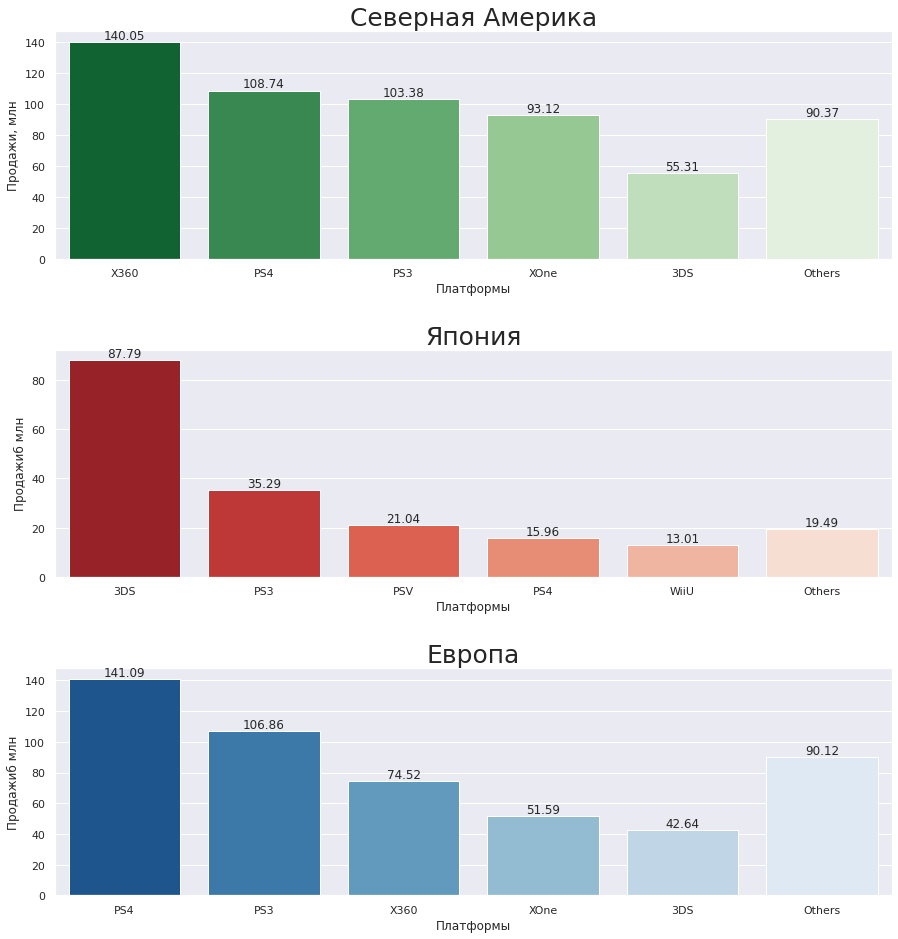

In [175]:
fig, ax = plt.subplots(3, figsize=(15,15))
sns.barplot(data=na_platform_group, x='platform', y='na_sales',ax=ax[0], palette='Greens_r')
sns.barplot(data=jp_platform_group, x='platform', y='jp_sales',ax=ax[1], palette='Reds_r')
sns.barplot(data=eu_platform_group, x='platform', y='eu_sales',ax=ax[2], palette='Blues_r')
ax[0].set_title('Северная Америка', size=25)
ax[1].set_title('Япония', size=25)
ax[2].set_title('Европа', size=25)
ax[0].set(ylabel='Продажи, млн')
ax[1].set(ylabel='Продажиб млн')
ax[2].set(ylabel='Продажиб млн')
ax[0].set(xlabel='Платформы')
ax[1].set(xlabel='Платформы')
ax[2].set(xlabel='Платформы')
ax[0].bar_label(ax[0].containers[0])
ax[1].bar_label(ax[1].containers[0])
ax[2].bar_label(ax[2].containers[0])
plt.subplots_adjust(bottom=0.1,top=0.9,wspace=0.4, hspace=0.4)
  
plt.show()

То же самое сделаем по жанрам:

In [176]:
na_genre_group = df_new.groupby('genre')['na_sales'].sum().reset_index()\
                .sort_values(by='na_sales',ascending=False)

na_genre_others = pd.DataFrame([['Others', na_genre_group.tail(len(na_genre_group)-5)\
                                    ['na_sales'].sum()]], columns=['genre','na_sales'], index=[100])
na_genre_group = na_genre_group.head()
na_genre_group = na_genre_group.append(na_genre_others)

In [177]:
jp_genre_group = df_new.groupby('genre')['jp_sales'].sum().reset_index()\
                .sort_values(by='jp_sales',ascending=False)

jp_genre_others = pd.DataFrame([['Others', jp_genre_group.tail(len(jp_genre_group)-5)\
                                    ['jp_sales'].sum()]], columns=['genre','jp_sales'], index=[100])
jp_genre_group = jp_genre_group.head()
jp_genre_group = jp_genre_group.append(jp_genre_others)

In [178]:
eu_genre_group = df_new.groupby('genre')['eu_sales'].sum().reset_index()\
                .sort_values(by='eu_sales',ascending=False)

eu_genre_others = pd.DataFrame([['Others', eu_genre_group.tail(len(eu_genre_group)-5)\
                                    ['eu_sales'].sum()]], columns=['genre','eu_sales'], index=[100])
eu_genre_group = eu_genre_group.head()
eu_genre_group = eu_genre_group.append(eu_genre_others)

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Если под "рядом" ты имел ввиду горизонтально, то сделаю это для жанров:
</div>

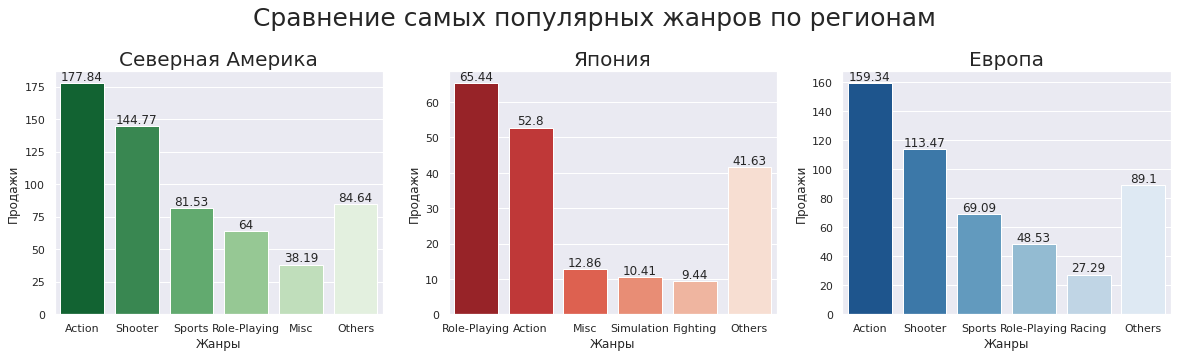

In [179]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.barplot(data=na_genre_group, x='genre', y='na_sales',ax=ax[0], palette='Greens_r')
sns.barplot(data=jp_genre_group, x='genre', y='jp_sales',ax=ax[1], palette='Reds_r')
sns.barplot(data=eu_genre_group, x='genre', y='eu_sales',ax=ax[2], palette='Blues_r')
fig.suptitle('Сравнение самых популярных жанров по регионам', size=25)
ax[0].set_title('Северная Америка', size=20)
ax[1].set_title('Япония', size=20)
ax[2].set_title('Европа', size=20)
ax[0].set(ylabel='Продажи')
ax[1].set(ylabel='Продажи')
ax[2].set(ylabel='Продажи')
ax[0].set(xlabel='Жанры')
ax[1].set(xlabel='Жанры')
ax[2].set(xlabel='Жанры')
ax[0].bar_label(ax[0].containers[0])
ax[1].bar_label(ax[1].containers[0])
ax[2].bar_label(ax[2].containers[0])
plt.subplots_adjust(top=0.8, wspace=0.2, hspace=0.4)
  
plt.show()

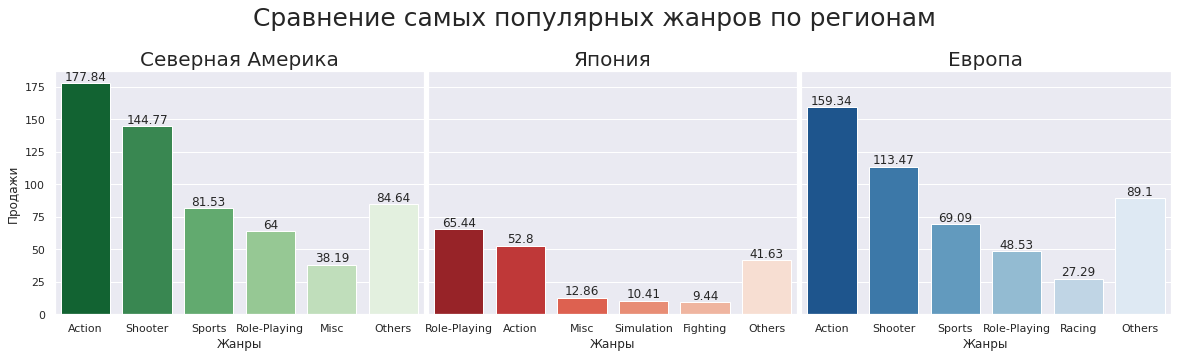

In [180]:
# check
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey = True)
sns.barplot(data=na_genre_group, x='genre', y='na_sales',ax=ax[0], palette='Greens_r')
sns.barplot(data=jp_genre_group, x='genre', y='jp_sales',ax=ax[1], palette='Reds_r')
sns.barplot(data=eu_genre_group, x='genre', y='eu_sales',ax=ax[2], palette='Blues_r')
fig.suptitle('Сравнение самых популярных жанров по регионам', size=25)
ax[0].set_title('Северная Америка', size=20)
ax[1].set_title('Япония', size=20)
ax[2].set_title('Европа', size=20)
ax[0].set(ylabel='Продажи')
ax[1].set(ylabel='')
ax[2].set(ylabel='')
ax[0].set(xlabel='Жанры')
ax[1].set(xlabel='Жанры')
ax[2].set(xlabel='Жанры')
ax[0].bar_label(ax[0].containers[0])
ax[1].bar_label(ax[1].containers[0])
ax[2].bar_label(ax[2].containers[0])
plt.subplots_adjust(top=0.8, wspace=0.01, hspace=0.4)
  
plt.show()

### 4.2 Самые популярные жанры

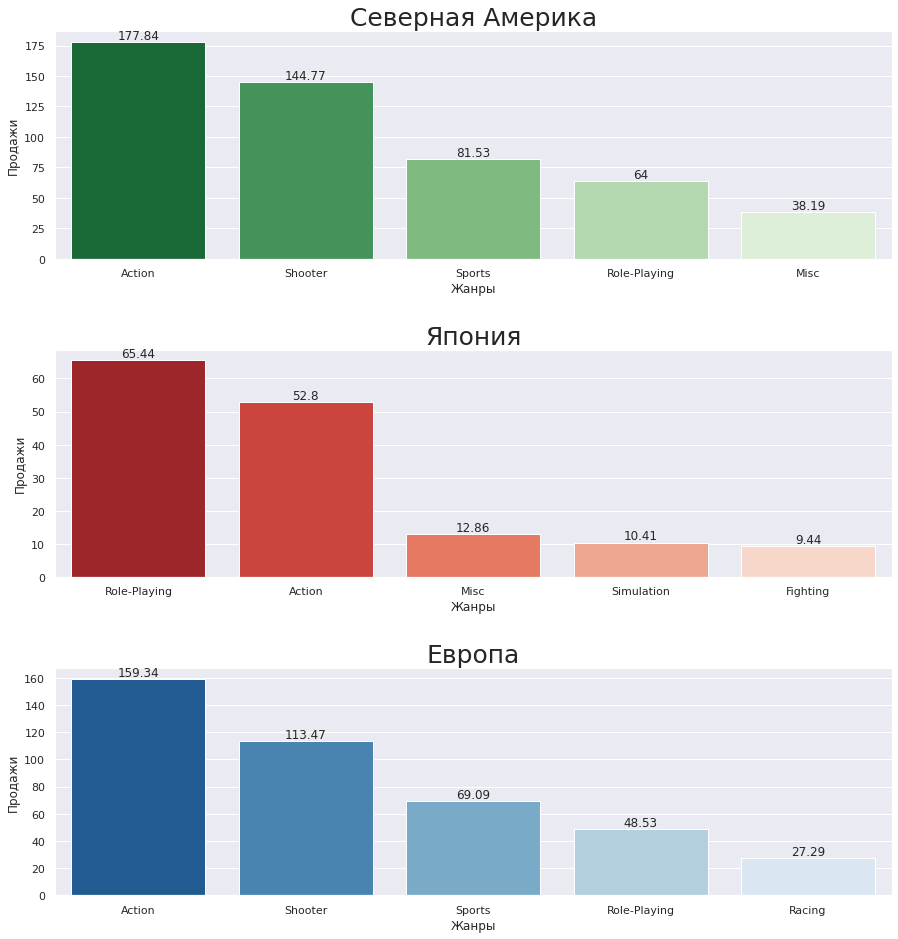

In [181]:
na_genre_group = df_new.groupby('genre')['na_sales'].sum().reset_index()\
                    .sort_values(by='na_sales',ascending=False).head()
jp_genre_group = df_new.groupby('genre')['jp_sales'].sum().reset_index()\
                    .sort_values(by='jp_sales',ascending=False).head()
eu_genre_group = df_new.groupby('genre')['eu_sales'].sum().reset_index()\
                    .sort_values(by='eu_sales',ascending=False).head()

fig, ax = plt.subplots(3, figsize=(15,15))
sns.barplot(data=na_genre_group, x='genre', y='na_sales',ax=ax[0], palette='Greens_r')
sns.barplot(data=jp_genre_group, x='genre', y='jp_sales',ax=ax[1], palette='Reds_r')
sns.barplot(data=eu_genre_group, x='genre', y='eu_sales',ax=ax[2], palette='Blues_r')
ax[0].set_title('Северная Америка', size=25)
ax[1].set_title('Япония', size=25)
ax[2].set_title('Европа', size=25)
ax[0].set(ylabel='Продажи')
ax[1].set(ylabel='Продажи')
ax[2].set(ylabel='Продажи')
ax[0].set(xlabel='Жанры')
ax[1].set(xlabel='Жанры')
ax[2].set(xlabel='Жанры')
ax[0].bar_label(ax[0].containers[0])
ax[1].bar_label(ax[1].containers[0])
ax[2].bar_label(ax[2].containers[0])
plt.subplots_adjust(bottom=0.1,top=0.9,wspace=0.4, hspace=0.4)
  
plt.show()

В Европе и в Северной Америке почти совпадают топ-5 предпочтений по жанрам. В лидерах "Action", "Shooter" и "Sports".
В Японии же лидируют "Role-playing", "Action" на втором месте, и далее с небольшой долей остальные. При этом жанра "Shooter" нет в первой пятерке.

По всем регионам игры в жанре "Action" ожидаемо занимают лидирующие позиции, это мы определили в разделе 3.6. Но в Японии предпочтения довольно сильно отличаются от Северной Америки и Европы.

### 4.3 Влияние рейтинга ESRB на продажи по регионам

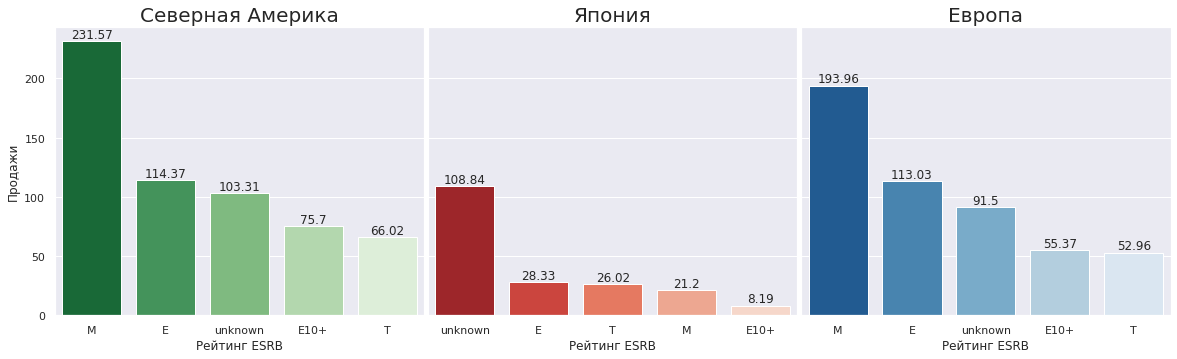

In [182]:
na_esrb_group = df_new.groupby('rating')['na_sales'].sum().reset_index().sort_values(by='na_sales',ascending=False)
jp_esrb_group = df_new.groupby('rating')['jp_sales'].sum().reset_index().sort_values(by='jp_sales',ascending=False)
eu_esrb_group = df_new.groupby('rating')['eu_sales'].sum().reset_index().sort_values(by='eu_sales',ascending=False)

fig, ax = plt.subplots(1,3, figsize=(20,5), sharey = True)
sns.barplot(data=na_esrb_group, x='rating', y='na_sales',ax=ax[0], palette='Greens_r')
sns.barplot(data=jp_esrb_group, x='rating', y='jp_sales',ax=ax[1], palette='Reds_r')
sns.barplot(data=eu_esrb_group, x='rating', y='eu_sales',ax=ax[2], palette='Blues_r')
ax[0].set_title('Северная Америка', size=20)
ax[1].set_title('Япония', size=20)
ax[2].set_title('Европа', size=20)
ax[0].set(ylabel='Продажи')
ax[1].set(ylabel='')
ax[2].set(ylabel='')
ax[0].set(xlabel='Рейтинг ESRB')
ax[1].set(xlabel='Рейтинг ESRB')
ax[2].set(xlabel='Рейтинг ESRB')
ax[0].bar_label(ax[0].containers[0])
ax[1].bar_label(ax[1].containers[0])
ax[2].bar_label(ax[2].containers[0])
plt.subplots_adjust(bottom=0.1,top=0.9, wspace=0.01, hspace=0.4);


В Японии количество продаваемых игр с отсутствующим возрастным рейтингом ESRB буквально зашкаливает. В Северной Америке и Европе таких игр тоже очень много, они на третьем месте.
Основываясь на факте о том что в разных странах разные рейтинговые модели(американская ESRB, европейская PEGI, японская CERO), можно предположить что игры с неизвестной категорией - это на самом деле японские игры, которые не оценены американским рейтинговым агенством. А учитывая, что выше мы выявили специфические предпочтения пользователей из Японии по жанрам и платформам, то можно предположить что предпочтения по играм у них тоже особые.

Для косвенного подтверждения этой гипотезы возьму самые популярные платформы в Японии японских производителей и проверю процент рейтинга "unknown" 



In [183]:
df_new.groupby('platform')['jp_sales'].count().sort_values()

platform
DS       31
Wii      54
WiiU    147
PSP     173
XOne    247
PC      250
X360    292
PS4     392
3DS     396
PSV     411
PS3     493
Name: jp_sales, dtype: int64

Сначала просто популярные японские платформы:

In [184]:
jap_pop_platforms = ['PS3','PSV','3DS','PS4','WiiU','PSP']

In [185]:
df_new[df_new.platform.isin(jap_pop_platforms)]['rating'].value_counts(normalize=True)

unknown    0.529324
T          0.139165
M          0.118290
E          0.115308
E10+       0.097913
Name: rating, dtype: float64

Теперь специфичные для Японии платформы(в основном портативные консоли):

In [186]:
jap_pop_platforms = ['PSV','3DS','WiiU','PSP']

In [187]:
df_new[df_new.platform.isin(jap_pop_platforms)]['rating'].value_counts(normalize=True)

unknown    0.652174
E10+       0.104703
E          0.101154
T          0.092280
M          0.049689
Name: rating, dtype: float64

Судя по всему, это действительно чисто японские игры, популярные в основном именно в Японии. 
    

Видно, что у Северной Америки и Европы распределение по жанрам абсолютно идентично. Больше всего игр продавалось для взрослых(17+), они лидируют с большим отрывом, далее игры которые подходят всем категориям возрастов. На последнем месте категория игр, рекомендованная для подростков(13+). В Японии же наоборот, на первом месте игры для всех категорий возрастов, далее игры для подростков, а игры с возрастным ограничением 17+ лишь на третьем месте. Хотя различия в объемах продаж не столь велика.

<font size=5>Вывод:</font>

В Северной Америке и Европе совпадают предпочтения пользователей по жанрам, так же одинаковое распределение продаваемых игр по возрастным категориям категориям. В Японии предпочтения по жанрам несколько отличаются, а возрастные категории совсем иные. Там совсем небольшие продажи в жанре "Shooter", отсюда и соответствующее распределение по возрастным ограничениям. Либо в Японии в игры больше играют дети и подростки, либо просто в целом пользователи предпочитают игры без насилия. В Северной Америке и Европе скорее всего пользователи - это взрослые люди, предпочитающие игры "Action" и "Shooter" с возрастными ограничениями 17+. Это очень интересное наблюдение.

## 5. Проверка гипотез

<font size=4>Средний пользовательский рейтинг Xbox One и PC </font>

H0(нулевая гипотеза): *средний пользовательский рейтинг платформ Xbox One и PC одинаковые*

H1(альтернативная гипотеза): *средний пользовательский рейтинг платформ Xbox One и PC отличаются*

Проверим количество наблюдений для каждой платформы:

In [188]:
xone = df_new[(df_new.platform=='XOne')&(df_new.user_score.notna())]
pc = df_new[(df_new.platform=='PC')&(df_new.year_of_release>2012)&(df_new.user_score.notna())]
print(f'Количество наблюдений для XOne: {len(xone)}')
print(f'Количество наблюдений для PC: {len(pc)}')

Количество наблюдений для XOne: 182
Количество наблюдений для PC: 155


Количество наблюдений выборок близки, можно сказать они одинаковые.

In [189]:
results = st.ttest_ind(
    xone['user_score'],
    pc['user_score'],
    equal_var=False)

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу ')
else:
    print('Не получилось отвергнуть нулевую гипотезу ')

0.14759594013430463
Не получилось отвергнуть нулевую гипотезу 


В нашем случае со средними оценками пользователей значение p-value равное 14.7% обозначает вероятность ошибки первого рода(то есть на самом деле нулевая гипотеза верна и средняя оценка пользователей для двух платформ совпадает, но мы получили противоположный  или ложноположительный результат). Ниже указаны средние оценки пользователей для нашей выборки: 6.52 и 6.27. Но с вероятностью почти 15% получить такое различие или большее различие можно получить случайно.
    
Если бы мы получили значение p-value, к примеру, равное 0.00001, то это означало бы что различия в средних оценках пользователей почти всегда получаются неслучайно и средние оценки не равны. 

Нулевая гипотеза верна, скорее всего у пользователей Xbox One и PC средняя оценка одинаковые. Проверим это:

In [190]:
xone_mean = xone.user_score.mean()
pc_mean = pc.user_score.mean()

print(f'Средняя оценка пользователей XOne: {xone_mean:.2f}')
print(f'Средняя оценка пользователей PC: {pc_mean:.2f}')


Средняя оценка пользователей XOne: 6.52
Средняя оценка пользователей PC: 6.27


Действительно, средние оценки практически одинаковые.

<font size=4>Средний пользовательский рейтинг игр жанра Action и Sports</font>

H0(нулевая гипотеза): *средний пользовательский рейтинг игр жанра "Action" и "Sports" одинаковые*

H1(альтернативная гипотеза): *средний пользовательский рейтинг игр жанра "Action" и "Sports" разные*

Посмотрим на размер выборок:

In [191]:
action = df_new[(df_new.genre=='Action')&(df_new.user_score.notna())]
sports = df_new[(df_new.genre=='Sports')&(df_new.user_score.notna())]
print(f'Количество наблюдений для жанра Action: {len(action)}')
print(f'Количество наблюдений для жанра Sports: {len(sports)}')

Количество наблюдений для жанра Action: 523
Количество наблюдений для жанра Sports: 195


Размер выборок сильно различается, поэтому мы позьмем случайные 195 строк с жанром Action и проведем t-тест

In [192]:
results = st.ttest_ind(
    action['user_score'].sample(195),
    sports['user_score'],
    equal_var=False)

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу ')
else:
    print('Не получилось отвергнуть нулевую гипотезу ')

6.378157851050276e-17
Отвергаем нулевую гипотезу 


То есть скорее всего средний пользовательский рейтинг жанров Action и Sports отличается. Проверим это:

In [193]:
action_mean = action.user_score.mean()
sports_mean = sports.user_score.mean()

print(f'Средняя оценка пользователей XOne: {action_mean:.2f}')
print(f'Средняя оценка пользователей PC: {sports_mean:.2f}')

Средняя оценка пользователей XOne: 6.83
Средняя оценка пользователей PC: 5.46


Действительно, различия в средних оценках пользователей для двух разных жанров отличается.

## 6. Итоговый вывод

Планируя кампанию на 2017 год, стоит учитывать следующие особенности:

- Самые перспективные платформы - это Sony Play Station 4 и Xbox One. Первая в случае ориентира на североамериканский рынок, вторая - европейский. Но в целом обе платформы пользуются большой популярностью в обоих регионах. При планировании кампаний на последующие годы стоит так же учитывать этих двух проихводителей - Sony и Microsoft, они на протяжении многих лет занимают лидирующие позиции на рынке. В случае с Японским рынком, напротив, стоит сконцентрироваться на мобильных платформах производства компании Nintendo.

- Основные самые популярные жанры: Action, Shooter, Role-Playing(RPG), Sports. Но стоит не забывать про то, что на Японском рынке шутеры скорее всего не будут иметь успеха из-за культурных особенностей.

- По возрастным ограничениям стоит отдать предпочтение играм для людей старше 17 лет - на них больше всего спрос. Однако в Японии больше пользуются популярностью игры для всех возрастных категорий и для подростков, надо иметь это ввиду. 

- При планировании и проведении кампании не стоит обращать внимание на оценку пользователей, как было показано выше, она не влияет на объемы продаж.